###Fase 0: preprocessing e analisi esplorativa




--- Starting Phase 0: Preprocessing and Exploratory Analysis ---

--- 1. Setup and Connection ---
Mounted at /content/drive
Google Drive connected successfully.

--- 2. Installing Libraries ---
Installation starting (this may take a minute)...
Library installation complete.

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas version: 2.2.2
Numpy version: 2.0.2

###   ACTION PLAN & MOTIVATIONS (PHASE 0)   ###

We are about to perform 5 key steps to prepare the data
for multi-omic analysis (MOFA and SNF).

1.  DATA ALIGNMENT:
    - WHAT: We will only keep the 137 patients present in ALL files.
    - WHY: MOFA and SNF require samples to be identical
      across all datasets to "fuse" them correctly.

2.  MISSING VALUE IMPUTATION (k-NN):
    - WHAT: We will fill empty cells (`NaN`) using the 5 most similar "neighbors".
    - WHY (Slide Validation): The slides (e.g., PCA_..., p. 38)
      warn that PCA "assumes no missing values". We chose
      k-NN as it is more ac

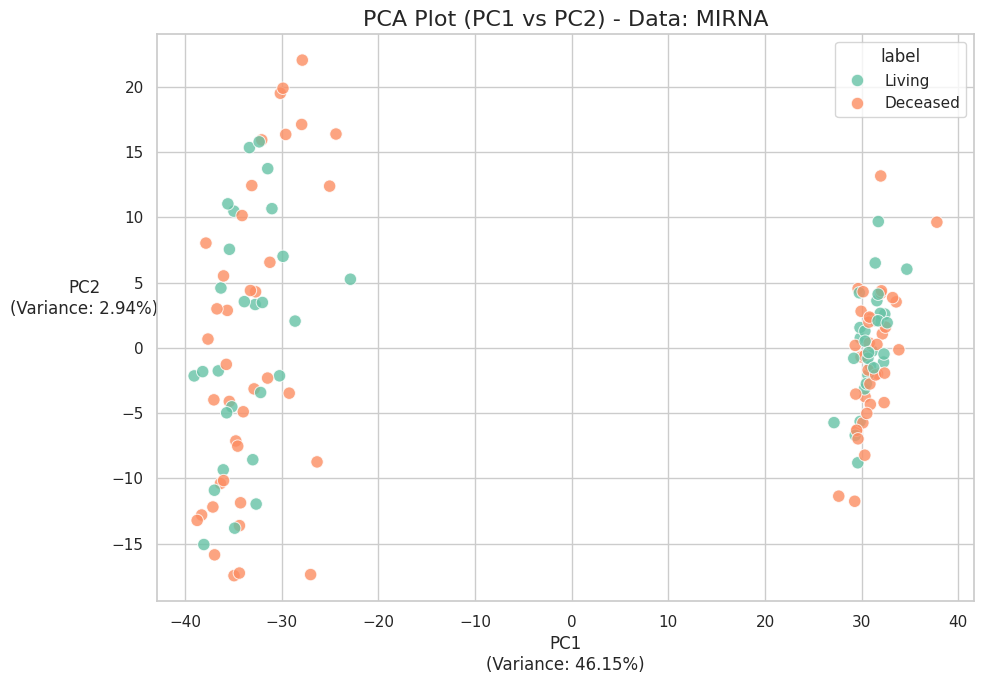

------------------------------------------------------------
INTERPRETATION (PCA miRNA):
This is the strongest result. The data clearly splits into 2 vertical 'islands'.
PC1 alone explains a massive 46% of the variance.
DISCOVERY: We found 2 robust biological subtypes. Note: colors (vital_status) are mixed in both groups. This division is NOT (only) related to survival.
------------------------------------------------------------
  > (Calculating Heatmap with metric 'correlation'...)


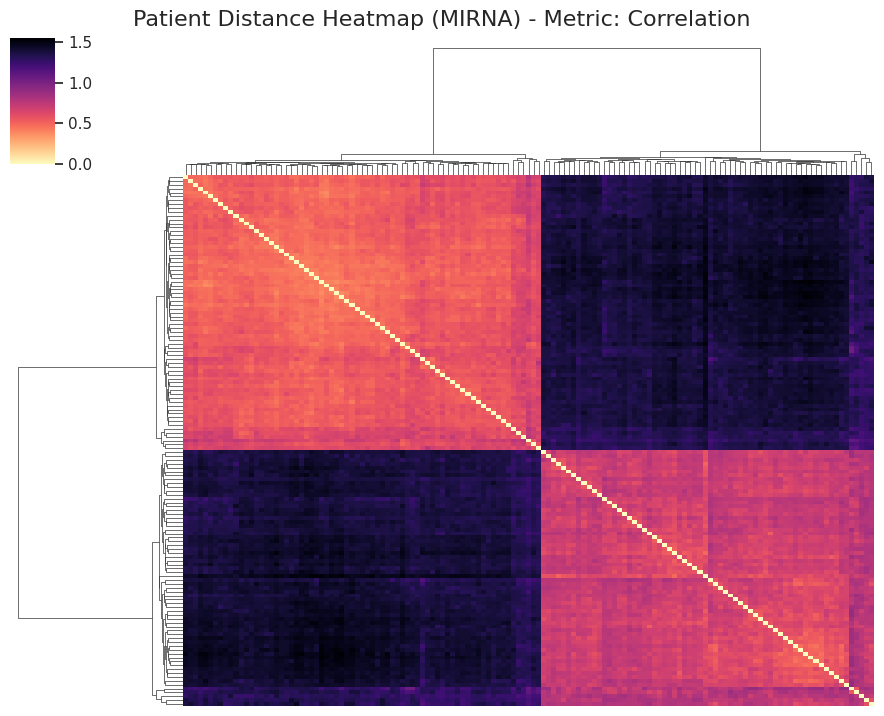

------------------------------------------------------------
INTERPRETATION (Heatmap miRNA):
This heatmap is the perfect confirmation of the PCA. The two large 'squares'
show 2 very compact and well-separated patient clusters.
This is a strong, clean signal, ideal for SNF.
------------------------------------------------------------


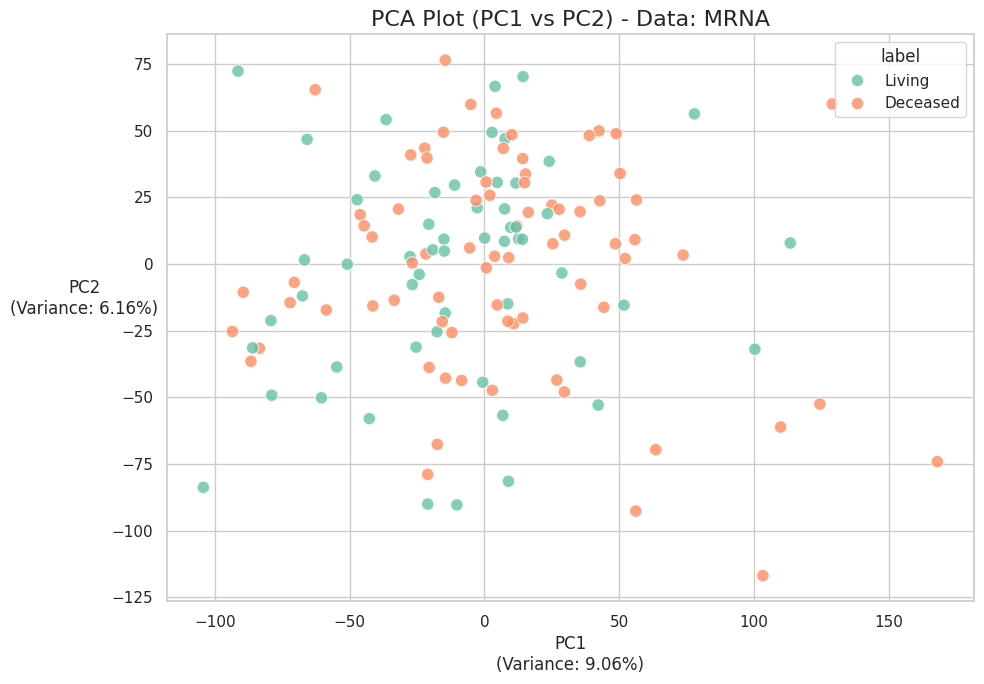

------------------------------------------------------------
INTERPRETATION (PCA mRNA):
This is our example of 'noise'. It's a chaotic cloud with no structure.
Colors (vital_status) are mixed, and variance explained is very low (9% + 6%).
DISCOVERY: mRNA data, by itself, is not sufficient to cluster patients.
------------------------------------------------------------
  > (Calculating Heatmap with metric 'correlation'...)


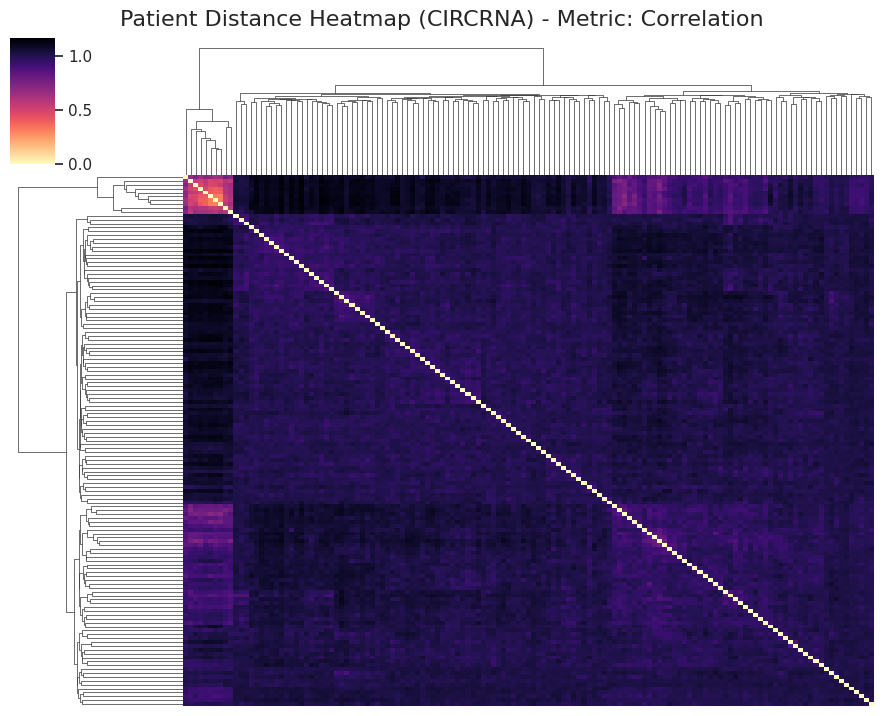

------------------------------------------------------------
INTERPRETATION (Heatmap circRNA):
This is the 'hidden discovery'. The PCA plot for circRNA was useless (a 'banana'),
but this heatmap reveals a small, very distinct square cluster.
DISCOVERY: A small subgroup of patients exists, which only this dataset
can see. This justifies the need for multi-omic integration.
------------------------------------------------------------

###   OPTIONAL GRAPHS (FOR 2D & 3D EXPLORATION)   ###
Use the menus below to explore the other graphs (2D and 3D).
--- Optional 2D Graph Controls ---


Output()


--- Optional 3D Graph Controls ---


Output()


--- PHASE 0 COMPLETE ---
Data is preprocessed and exploratory analysis is finished.


In [ ]:
# =======================================================================
#    PROGETTO PDAC - FASE 0: PREPROCESSING E ANALISI ESPLORATIVA
# =======================================================================
#
# OBIETTIVO:
# Questo script unico esegue l'intera Fase 0:
# 1. Stampa il "Piano d'Azione" (in Inglese) con le motivazioni.
# 2. Esegue tutto il preprocessing dei dati (Allineamento, Imputazione, Scaling).
# 3. Mostra i 4 grafici esplorativi "chiave" con titoli in INGLESE
#    e interpretazione in INGLESE.
# 4. Fornisce un menu interattivo per esplorare gli altri grafici.
#
# =======================================================================

print("--- Starting Phase 0: Preprocessing and Exploratory Analysis ---")

# --- 1. SETUP AND DRIVE CONNECTION ---
print("\n--- 1. Setup and Connection ---")
try:
    from google.colab import drive
    # force_remount=True forza la riconnessione e risolve i problemi di cache
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive connected successfully.")
except ImportError:
    print("Script not run in Google Colab. Assuming local files.")
except Exception as e:
    print(f"\nERROR CONNECTING TO DRIVE: {e}")
    if "credential propagation" in str(e):
        print("This is often a BROWSER COOKIE problem.")
        print("SOLUTION: Try running the notebook in an INCOGNITO WINDOW.")
    raise e

# --- 2. INSTALL LIBRARIES (Silent) ---
print("\n--- 2. Installing Libraries ---")
print("Installation starting (this may take a minute)...")
!pip install mofapy2 > /dev/null 2>&1
!pip install snfpy > /dev/null 2>&1
!pip install umap-learn > /dev/null 2>&1 # Necessario per UMAP
!pip install forceatlas2 > /dev/null 2>&1 # Per Fasi successive
!pip install scikit-learn pandas numpy > /dev/null 2>&1
print("Library installation complete.")

# --- 3. IMPORT MAIN LIBRARIES ---
import pandas as pd
import numpy as np
import snf
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from ipywidgets import interact, widgets, VBox, HBox, Output
from IPython.display import display, clear_output
import plotly.express as px
import networkx as nx
from sklearn.manifold import TSNE
from umap import UMAP
import warnings
from sklearn.exceptions import DataConversionWarning
try:
    from forceatlas2 import ForceAtlas2
except ImportError:
    print("Warning: 'forceatlas2' not imported. Will use NetworkX layouts.")

# --- FIX: Imposta un tema grafico scientifico e pulito ---
sns.set_theme(style="whitegrid", palette="Set2")

# IGNORA I WARNING (non sono errori)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)


print(f"\nPython version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

# =======================================================================
# --- 4. ACTION PLAN (As requested, in English) ---
# =======================================================================
print("\n" + "="*70)
print("###   ACTION PLAN & MOTIVATIONS (PHASE 0)   ###")
print("="*70)
print("""
We are about to perform 5 key steps to prepare the data
for multi-omic analysis (MOFA and SNF).

1.  DATA ALIGNMENT:
    - WHAT: We will only keep the 137 patients present in ALL files.
    - WHY: MOFA and SNF require samples to be identical
      across all datasets to "fuse" them correctly.

2.  MISSING VALUE IMPUTATION (k-NN):
    - WHAT: We will fill empty cells (`NaN`) using the 5 most similar "neighbors".
    - WHY (Slide Validation): The slides (e.g., PCA_..., p. 38)
      warn that PCA "assumes no missing values". We chose
      k-NN as it is more accurate than simple column mean.

3.  LOG TRANSFORM (log1p):
    - WHAT: We will apply Log(x+1) to continuous data.
    - WHY (Slide Validation): The slides (PCA_..., p. 38)
      explain that PCA fails with "non-linear relationships"
      and recommends "log transforms".

4.  SCALING (Z-score):
    - WHAT: We will standardize the data (mean=0, std=1).
    - WHY (Slide Validation): This is MANDATORY. The slides
      (PCA_..., p. 10, 38) state "it is so important to standardize
      the values first".

5.  EXPLORATORY ANALYSIS (PCA / Heatmap):
    - WHAT: We will generate plots to "peek" inside each dataset.
    - WHY (Slide Validation): This is our first check. Heatmaps
      (SimNetX, p. 23) are the basis for SNF, and PCA plots
      (PCA_..., p. 45) are the basis for MOFA.
""")

# =======================================================================
# --- 5. DATA LOADING ---
# =======================================================================
print("\n--- 5. Loading Data ---")
GDRIVE_PATH = "/content/drive/MyDrive/dataset/"
print(f"Loading data from folder: {GDRIVE_PATH}")

try:
    f_mrna_raw = pd.read_csv(GDRIVE_PATH + 'mRNA.csv', index_col=0)
    f_mirna_raw = pd.read_csv(GDRIVE_PATH + 'miRNA.csv', index_col=0)
    f_prot_raw = pd.read_csv(GDRIVE_PATH + 'proteome_gene.csv', index_col=0)
    f_fosfo_raw = pd.read_csv(GDRIVE_PATH + 'phosphoproteome_gene.csv', index_col=0)
    f_mut_raw = pd.read_csv(GDRIVE_PATH + 'SCNA_gene.csv', index_col=0)
    f_circrna_raw = pd.read_csv(GDRIVE_PATH + 'circRNA.csv', index_col=0)
    f_clin_raw = pd.read_csv(GDRIVE_PATH + 'clinical_data.csv', index_col=0)
    print("Raw data loading complete.")
except Exception as e:
    print(f"\nERROR: Files not found at '{GDRIVE_PATH}'. {e}")
    print("SOLUTION: Ensure you have created the 'dataset' shortcut in 'My Drive'.")
    raise e

# =======================================================================
# --- 6. PHASE 0.1: DATA ALIGNMENT ---
# =======================================================================
print("\n--- 6. Phase 0.1: Aligning Data... ---")
omics_dfs_raw = {
    'mrna': f_mrna_raw, 'mirna': f_mirna_raw, 'prot': f_prot_raw,
    'fosfo': f_fosfo_raw, 'mut': f_mut_raw, 'circrna': f_circrna_raw
}
clinical_patients = set(f_clin_raw.index)
omics_patients_sets = [set(df.columns) for df in omics_dfs_raw.values()]
common_patients = set.intersection(clinical_patients, *omics_patients_sets)
common_patients_list = sorted(list(common_patients))
print(f"Common patients found in ALL files: {len(common_patients_list)}")
omics_dfs_aligned = {}
for name, df_raw in omics_dfs_raw.items():
    df_aligned = df_raw[common_patients_list].T
    omics_dfs_aligned[name] = df_aligned.sort_index()
f_clin_aligned = f_clin_raw.loc[common_patients_list].sort_index()
print("Alignment complete.")

# =======================================================================
# --- 7. PHASE 0.2: MISSING VALUE IMPUTATION ---
# =======================================================================
print("\n--- 7. Phase 0.2: Imputing Missing Values... ---")
continuous_omics_names = ['mrna', 'mirna', 'prot', 'fosfo', 'circrna']
imputed_omics_dfs = {}
imputer_knn = KNNImputer(n_neighbors=5)
for name in continuous_omics_names:
    df = omics_dfs_aligned[name].copy()
    all_nan_cols = df.columns[df.isna().all()]
    if not all_nan_cols.empty:
        print(f"  > WARNING '{name}': Removed {len(all_nan_cols)} completely empty columns.")
        df = df.drop(columns=all_nan_cols)
    idx, cols = df.index, df.columns
    if df.isna().sum().sum() > 0:
        df_imputed_array = imputer_knn.fit_transform(df)
    else:
        df_imputed_array = df.values
    imputed_omics_dfs[name] = pd.DataFrame(df_imputed_array, index=idx, columns=cols)
df_mut = omics_dfs_aligned['mut']
imputed_omics_dfs['mut'] = df_mut.fillna(0).astype(int)
f_clin_imputed = f_clin_aligned.copy()
for col in f_clin_imputed.columns:
    if pd.api.types.is_numeric_dtype(f_clin_imputed[col]):
        f_clin_imputed[col] = f_clin_imputed[col].fillna(f_clin_imputed[col].median())
    else:
        f_clin_imputed[col] = f_clin_imputed[col].fillna(f_clin_imputed[col].mode()[0])
print("Imputation complete.")

# =======================================================================
# --- 8. PHASE 0.3: TRANSFORM & SCALING ---
# =======================================================================
print("\n--- 8. Phase 0.3: Transforming and Scaling... ---")
scaled_omics_dfs = {}
scaler = StandardScaler()
for name in continuous_omics_names:
    df = imputed_omics_dfs[name]
    df_log = np.log1p(df) if df.min().min() >= 0 else df
    idx, cols = df_log.index, df_log.columns
    df_scaled_array = scaler.fit_transform(df_log)
    scaled_omics_dfs[name] = pd.DataFrame(df_scaled_array, index=idx, columns=cols)
scaled_omics_dfs['mut'] = imputed_omics_dfs['mut']
print("Scaling complete.")

# =======================================================================
# --- 9. PHASE 0.4: CLINICAL DATA TRANSFORM ---
# =======================================================================
print("\n--- 9. Phase 0.4: Transforming Clinical Data... ---")
df_clin_proc = f_clin_imputed.copy()
numeric_cols = df_clin_proc.select_dtypes(include=np.number).columns
categorical_cols = df_clin_proc.select_dtypes(exclude=np.number).columns
processed_dfs = []
if not numeric_cols.empty:
    scaler_clin = StandardScaler()
    df_numeric_scaled = pd.DataFrame(scaler_clin.fit_transform(df_clin_proc[numeric_cols]),
        index=df_clin_proc.index, columns=numeric_cols)
    processed_dfs.append(df_numeric_scaled)
if not categorical_cols.empty:
    encoder_clin = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')
    encoded_data = encoder_clin.fit_transform(df_clin_proc[categorical_cols])
    encoded_cols = encoder_clin.get_feature_names_out(categorical_cols)
    df_encoded = pd.DataFrame(encoded_data, index=df_clin_proc.index, columns=encoded_cols)
    processed_dfs.append(df_encoded)
f_clin_final = pd.concat(processed_dfs, axis=1)
print("Clinical data transformation complete.")
print("\n" + "="*70)
print("###   PHASE 0 PREPROCESSING COMPLETE   ###")
print("="*70)

# =======================================================================
# --- 10. FASE 0.5: INTERACTIVE EXPLORATORY ANALYSIS ---
# =======================================================================
print("\n" + "="*70)
print("###   PHASE 0.5: INTERACTIVE EXPLORATORY ANALYSIS   ###")
print("="*70)

label_to_plot = 'vital_status'
plot_label_data = f_clin_aligned[label_to_plot] if label_to_plot in f_clin_aligned.columns else pd.Series('Patient', index=f_clin_aligned.index, name='label')

# --- Funzioni di Plotting  ---

def print_interpretazione_en(nome_grafico):
    """Prints a text interpretation for the key graphs."""
    print("-" * 60)
    if nome_grafico == 'PCA_miRNA':
        print("INTERPRETATION (PCA miRNA):")
        print("This is the strongest result. The data clearly splits into 2 vertical 'islands'.")
        print("PC1 alone explains a massive 46% of the variance.")
        print("DISCOVERY: We found 2 robust biological subtypes. Note: colors (vital_status) are mixed in both groups. This division is NOT (only) related to survival.")
    elif nome_grafico == 'Heatmap_miRNA':
        print("INTERPRETATION (Heatmap miRNA):")
        print("This heatmap is the perfect confirmation of the PCA. The two large 'squares'")
        print("show 2 very compact and well-separated patient clusters.")
        print("This is a strong, clean signal, ideal for SNF.")
    elif nome_grafico == 'PCA_mRNA':
        print("INTERPRETATION (PCA mRNA):")
        print("This is our example of 'noise'. It's a chaotic cloud with no structure.")
        print("Colors (vital_status) are mixed, and variance explained is very low (9% + 6%).")
        print("DISCOVERY: mRNA data, by itself, is not sufficient to cluster patients.")
    elif nome_grafico == 'Heatmap_circrna':
        print("INTERPRETATION (Heatmap circRNA):")
        print("This is the 'hidden discovery'. The PCA plot for circRNA was useless (a 'banana'),")
        print("but this heatmap reveals a small, very distinct square cluster.")
        print("DISCOVERY: A small subgroup of patients exists, which only this dataset")
        print("can see. This justifies the need for multi-omic integration.")
    print("-" * 60)

def genera_grafico_en(nome_grafico, is_key_graph=False):
    """Generates a 2D PCA plot or a Heatmap with English labels."""
    try:
        tipo_grafico, nome_omico = nome_grafico.split('_', 1)
        nome_omico = nome_omico.lower()
        if nome_omico not in scaled_omics_dfs: return
        omic_data = scaled_omics_dfs[nome_omico]

        if tipo_grafico.lower() == 'pca':
            pca = PCA(n_components=2)
            principal_components = pca.fit_transform(omic_data)
            pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'], index=omic_data.index)
            pca_df['label'] = plot_label_data

            plt.figure(figsize=(10, 7))
            # --- FIX: Usa una palette qualitativa (Set2) per i colori ---
            sns.scatterplot(x='PC1', y='PC2', hue='label', data=pca_df, alpha=0.8, s=80, palette='Set2')
            plt.title(f"PCA Plot (PC1 vs PC2) - Data: {nome_omico.upper()}", fontsize=16)
            plt.xlabel(f"PC1\n(Variance: {pca.explained_variance_ratio_[0]*100:.2f}%)", fontsize=12)
            plt.ylabel(f"PC2\n(Variance: {pca.explained_variance_ratio_[1]*100:.2f}%)",
            fontsize=12,
            rotation=0,
            labelpad=20,  # Sposta l'etichetta a sinistra per non sovrapporsi
            )   # Allinea le due righe a destra            plt.legend(title=label_to_plot, bbox_to_anchor=(1.05, 1), loc='upper left')
            # Rimuove le griglie di default (
            # plt.grid(True, linestyle='--', alpha=0.5)
            plt.tight_layout()
            plt.show()

        elif tipo_grafico.lower() == 'heatmap':
            data_sample = np.random.choice(omic_data.values.flatten(), min(50000, omic_data.size), replace=False)
            num_unique = np.unique(data_sample).size
            heatmap_metric = "correlation"
            if num_unique <= 2: heatmap_metric = "jaccard"
            elif num_unique < 20 and np.allclose(np.unique(data_sample), np.round(np.unique(data_sample))): heatmap_metric = "hamming"

            print(f"  > (Calculating Heatmap with metric '{heatmap_metric}'...)")
            try:
                distance_matrix = pairwise_distances(omic_data.values, metric=heatmap_metric)
            except ValueError:
                heatmap_metric = 'euclidean'
                distance_matrix = pairwise_distances(omic_data.values, metric=heatmap_metric)

            distance_df = pd.DataFrame(distance_matrix, index=omic_data.index, columns=omic_data.index)

            # --- FIX: Rimuove l'etichetta verticale dell'asse Y (cbar_kws) ---
            g = sns.clustermap(distance_df, cmap='magma_r', xticklabels=False, yticklabels=False,
                figsize=(9, 7)) # cbar_kws rimosso

            # --- FIX: Aggiunge la metrica al titolo principale ---
            g.fig.suptitle(f"Patient Distance Heatmap ({nome_omico.upper()}) - Metric: {heatmap_metric.capitalize()}", fontsize=16, y=1.02)
            plt.show()

        # Stampa l'interpretazione se è un grafico chiave
        if is_key_graph:
            print_interpretazione_en(nome_grafico)

    except Exception as e:
        print(f"Error generating graph '{nome_grafico}': {e}")

def genera_pca_3d_en(nome_omico):
    """Generates an optional 3D PCA plot with English labels."""
    try:
        nome_omico = nome_omico.lower()
        if nome_omico not in scaled_omics_dfs: return
        omic_data = scaled_omics_dfs[nome_omico]
        print(f"\nGenerating 3D PCA Plot for: {nome_omico.upper()}...")
        pca = PCA(n_components=3)
        principal_components = pca.fit_transform(omic_data)
        pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2', 'PC3'], index=omic_data.index)
        pca_df['label'] = plot_label_data
        var_pc1 = pca.explained_variance_ratio_[0] * 100
        var_pc2 = pca.explained_variance_ratio_[1] * 100
        var_pc3 = pca.explained_variance_ratio_[2] * 100
        total_variance_3d = var_pc1 + var_pc2 + var_pc3
        print("-" * 60)
        print("CRITICAL ANALYSIS (Reference Slide: 'PCA_...', p. 46):")
        print(f"Total Variance Explained (PC1+PC2+PC3): {total_variance_3d:.2f}%")
        if total_variance_3d < 30:
            print("WARNING: Total variance is very low. This 3D plot is")
            print("ignoring most of the information and will likely appear")
            print("as a 'big gray cloud', as noted in the slides.")
        else:
            print("INFO: Total variance is discrete. This plot might reveal structure.")
        print("-" * 60)

        # --- FIX: Usa la stessa palette 'Set2' per coerenza ---
        fig = px.scatter_3d(
            pca_df, x='PC1', y='PC2', z='PC3',
            color='label',
            hover_name=pca_df.index,
            title=f"3D PCA Plot - Data: {nome_omico.upper()}",
            labels={'label': label_to_plot},
            color_discrete_sequence=sns.color_palette('Set2').as_hex() # Palette coerente
        )
        fig.update_layout(scene=dict(
            xaxis_title=f'PC1 ({var_pc1:.2f}%)',
            yaxis_title=f'PC2 ({var_pc2:.2f}%)',
            zaxis_title=f'PC3 ({var_pc3:.2f}%)'
        ))
        fig.show()

    except Exception as e:
        print(f"Error generating 3D PCA: {e}")

# --- Show Key Graphs (Phase 0.5) ---
GRAFICI_CHIAVE = ['PCA_miRNA', 'Heatmap_miRNA', 'PCA_mRNA', 'Heatmap_circrna']
print("\n" + "="*70)
print("###   KEY GRAPHS (MOST IMPORTANT FINDINGS)   ###")
print("="*70)
for nome in GRAFICI_CHIAVE:
    genera_grafico_en(nome, is_key_graph=True)

# --- Create Menu for Optional Graphs (Phase 0.5) ---
print("\n" + "="*70)
print("###   OPTIONAL GRAPHS (FOR 2D & 3D EXPLORATION)   ###")
print("="*70)
print("Use the menus below to explore the other graphs (2D and 3D).")
tutti_i_grafici = []
for nome_omico in scaled_omics_dfs.keys():
    tutti_i_grafici.append(f"PCA_{nome_omico}")
    tutti_i_grafici.append(f"Heatmap_{nome_omico}")
grafici_opzionali = sorted([g for g in tutti_i_grafici if g not in GRAFICI_CHIAVE])
lista_dataset_opzionali = sorted(list(scaled_omics_dfs.keys()))
dropdown_2d = widgets.Dropdown(options=grafici_opzionali, description='Optional 2D Graph:', style={'description_width': 'initial'})
button_2d = widgets.Button(description='Show 2D Graph', button_style='info')
output_2d = widgets.Output()
def on_button_2d_click(b):
    with output_2d:
        clear_output(wait=True)
        genera_grafico_en(dropdown_2d.value)
button_2d.on_click(on_button_2d_click)
dropdown_3d = widgets.Dropdown(options=lista_dataset_opzionali, description='Dataset for 3D PCA:', style={'description_width': 'initial'})
button_3d = widgets.Button(description='Show 3D PCA', button_style='success')
output_3d = widgets.Output()
def on_button_3d_click(b):
    with output_3d:
        clear_output(wait=True)
        genera_pca_3d_en(dropdown_3d.value)
button_3d.on_click(on_button_3d_click)
print("--- Optional 2D Graph Controls ---")
display(HBox([dropdown_2d, button_2d]))
display(output_2d)
print("\n--- Optional 3D Graph Controls ---")
display(HBox([dropdown_3d, button_3d]))
display(output_3d)

# --- Final Comment ---
print("\n" + "="*70)
print("--- PHASE 0 COMPLETE ---")
print("Data is preprocessed and exploratory analysis is finished.")


********************************************************************************
###Inizio Track A
********************************************************************************


********************************************************************************
###Fase 1: Track A                                                             
********************************************************************************

In [ ]:

# =======================================================================
#     PROGETTO PDAC - SCRIPT  (FASE 0_Adattata + FASE 1)
# =======================================================================

print("--- Avvio Script (Fase 0 e Fase 1) ---")

# --- 1. SETUP E CONNESSIONE A GOOGLE DRIVE ---
print("\n--- 1. Setup e Connessione ---")
try:
    from google.colab import drive
    drive.mount('/content/drive')
    print("Google Drive connesso con successo.")
except ImportError:
    print("Script non eseguito in Google Colab. Assumo che i file siano locali.")

# --- 2. INSTALLAZIONE LIBRERIE (Output silenziato) ---
# (Manteniamo le installazioni originali per completezza)
print("\n--- 2. Installazione Librerie ---")
!pip install mofapy2 > /dev/null 2>&1
!pip install snfpy > /dev/null 2>&1
!pip install scikit-learn pandas numpy > /dev/null 2>&1
!pip install umap-learn > /dev/null 2>&1
!pip install lifelines statsmodels > /dev/null 2>&1
!pip install plotly > /dev/null 2>&1
print("Installazione librerie completata.")

# --- 3. IMPORT LIBRERIE PRINCIPALI ---
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from ipywidgets import interact, widgets, VBox, HBox, Output
from IPython.display import display, clear_output

# (Import di mofapy2 e altri non necessari per il PIVOT, ma li lasciamo)
import mofapy2
from mofapy2.run.entry_point import entry_point
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn.manifold import TSNE
import umap.umap_ as umap
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import silhouette_score
from lifelines import KaplanMeierFitter
from lifelines.statistics import multivariate_logrank_test
import statsmodels.api as sm
import statsmodels.formula.api as smf
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'colab'

print(f"\nPython version: {sys.version}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")

# =======================================================================
# --- FASE 0: PREPROCESSING (Blocchi 4-9) ---
# =======================================================================
print("\n" + "="*70)
print("### FASE 0: CARICAMENTO E PREPROCESSING DATI ###")
print("="*70)

# 5. CARICAMENTO DATI
GDRIVE_PATH = "/content/drive/MyDrive/dataset/"
try:
    f_mrna_raw = pd.read_csv(GDRIVE_PATH + 'mRNA.csv', index_col=0)
    f_mirna_raw = pd.read_csv(GDRIVE_PATH + 'miRNA.csv', index_col=0)
    f_prot_raw = pd.read_csv(GDRIVE_PATH + 'proteome_gene.csv', index_col=0)
    f_fosfo_raw = pd.read_csv(GDRIVE_PATH + 'phosphoproteome_gene.csv', index_col=0)
    f_mut_raw = pd.read_csv(GDRIVE_PATH + 'SCNA_gene.csv', index_col=0)
    f_circrna_raw = pd.read_csv(GDRIVE_PATH + 'circRNA.csv', index_col=0)
    f_clin_raw = pd.read_csv(GDRIVE_PATH + 'clinical_data.csv', index_col=0)
except Exception as e:
    print(f"ERRORE: File non trovati. {e}")
    raise e

# 6. ALLINEAMENTO DATI
print("\n--- 6. Fase 0.1: Allineamento Dati... ---")
omics_dfs_raw = {'mrna': f_mrna_raw, 'mirna': f_mirna_raw, 'prot': f_prot_raw,
                  'fosfo': f_fosfo_raw, 'mut': f_mut_raw, 'circrna': f_circrna_raw}
clinical_patients = set(f_clin_raw.index)
omics_patients_sets = [set(df.columns) for df in omics_dfs_raw.values()]
common_patients = set.intersection(clinical_patients, *omics_patients_sets)
common_patients_list = sorted(list(common_patients))

omics_dfs_aligned = {}
for name, df_raw in omics_dfs_raw.items():
    df_aligned = df_raw[common_patients_list].T
    df_aligned = df_aligned.sort_index()
    omics_dfs_aligned[name] = df_aligned
f_clin_aligned = f_clin_raw.loc[common_patients_list].sort_index()
print(f"Pazienti comuni allineati: {len(common_patients_list)}.")

# 7. & 8. IMPUTAZIONE E SCALING (CON FIX PER I NaN)
print("\n--- 7 & 8: Imputazione (k-NN) e Scaling (Z-score, log1p)... ---")
continuous_omics_names = ['mrna', 'mirna', 'prot', 'fosfo', 'circrna']
imputer_knn = KNNImputer(n_neighbors=5)
scaler = StandardScaler()
scaled_omics_dfs = {} # Dati per Fase 1 PIVOT

# Dati clinici imputati (per FASE 3)
f_clin_imputed = f_clin_aligned.copy()
for col in f_clin_imputed.columns:
    if pd.api.types.is_numeric_dtype(f_clin_imputed[col]):
        f_clin_imputed[col] = f_clin_imputed[col].fillna(f_clin_imputed[col].median())
    else:
        f_clin_imputed[col] = f_clin_imputed[col].fillna(f_clin_imputed[col].mode()[0])

for name in omics_dfs_aligned.keys():
    df = omics_dfs_aligned[name].copy()
    df = df.drop(columns=df.columns[df.isna().all()], errors='ignore')

    if name in continuous_omics_names:
        df_imputed = pd.DataFrame(imputer_knn.fit_transform(df), index=df.index, columns=df.columns)
        df_log = np.log1p(df_imputed)

        # Scaling (con FIX per varianza zero)
        df_scaled_array = scaler.fit_transform(df_log)

        # ============================ FIX APPLICATO QUI ============================
        # Controlliamo se lo scaling ha introdotto NaN (a causa di varianza zero)
        if np.isnan(df_scaled_array).any():
            print(f"  > ATTENZIONE '{name}': Rilevati NaN dopo lo scaling (varianza zero). Riempimento con 0.")
            # Sostituiamo i NaN creati (risultato di 0/0) con 0.
            df_scaled_array = np.nan_to_num(df_scaled_array, nan=0.0)
        # =========================================================================

        scaled_omics_dfs[name] = pd.DataFrame(df_scaled_array, index=df.index, columns=df.columns)
    else:
        scaled_omics_dfs[name] = df.fillna(0).astype(int)

# 9. TRASFORMAZIONE DATI CLINICI (Per Fase 3 - LR)
print("\n--- 9. Fase 0.4: Trasformazione Dati Clinici... ---")
# (Usiamo f_clin_imputed per assicurarci che non ci siano NaN)
numeric_cols = f_clin_imputed.select_dtypes(include=np.number).columns
categorical_cols = f_clin_imputed.select_dtypes(exclude=np.number).columns
processed_dfs = []

if not numeric_cols.empty:
    scaler_clin = StandardScaler()
    df_numeric_scaled = pd.DataFrame(scaler_clin.fit_transform(f_clin_imputed[numeric_cols]),
                                     index=f_clin_imputed.index, columns=numeric_cols)
    processed_dfs.append(df_numeric_scaled)

if not categorical_cols.empty:
    encoder_clin = OneHotEncoder(sparse_output=False, drop='if_binary', handle_unknown='ignore')
    encoded_data = encoder_clin.fit_transform(f_clin_imputed[categorical_cols])
    encoded_cols = encoder_clin.get_feature_names_out(categorical_cols)
    df_encoded = pd.DataFrame(encoded_data, index=f_clin_imputed.index, columns=encoded_cols)
    processed_dfs.append(df_encoded)

f_clin_final = pd.concat(processed_dfs, axis=1) # Dati clinici pronti per la LR
print("Preprocessing (Fase 0) completato.")


# =======================================================================
# --- FASE 1: INTEGRAZIONE (PIVOT: PCA SU MEGA-MATRICE) ---
# =======================================================================
print("\n" + "="*70)
print("### FASE 1: PIVOT - Integrazione tramite Concatenazione e PCA ###")
print("="*70)

data_to_integrate = []
view_names_list = []
print("> Concatenazione dati pre-processati (Fase 0)...")
samples_ref = scaled_omics_dfs['mrna'].index.tolist()

for view_name, df in scaled_omics_dfs.items():
    print(f"  - Aggiungo {view_name} (Shape: {df.shape})")
    df_renamed = df.add_prefix(f"{view_name}_")
    data_to_integrate.append(df_renamed)
    view_names_list.append(view_name)

mega_matrix = pd.concat(data_to_integrate, axis=1)
print(f"\n> Mega-Matrice creata. Shape Finale: {mega_matrix.shape}")

N_FACTORS = 15
pca = PCA(n_components=N_FACTORS, random_state=42)
print(f"> Esecuzione PCA su Mega-Matrice per estrarre {N_FACTORS} fattori...")

# Ora questo step funzionerà grazie al FIX np.nan_to_num(..., nan=0.0)
Z_matrix = pca.fit_transform(mega_matrix)

latent_factors_df = pd.DataFrame(
    Z_matrix,
    index=samples_ref,
    columns=[f"Factor_{i+1}" for i in range(N_FACTORS)]
)
print("\n*** FASE 1 (PIVOT) COMPLETATA. Matrice Fattori Latenti creata. ***")
print(f"Dimensione Matrice Fattori: {latent_factors_df.shape}")

# --- ANALISI LOADINGS (Interpretazione Biologica) ---
print("\n--- Analisi Loadings: Contributo Omico ai Primi 3 Fattori ---")
feature_names = mega_matrix.columns
for i in range(min(3, N_FACTORS)):
    factor_name = latent_factors_df.columns[i]
    print(f"\nLoadings per {factor_name}:")
    loadings = pca.components_[i]
    factor_loadings = {}
    total_var = np.sum(loadings**2)
    for view in view_names_list:
        view_prefix = f"{view}_"
        view_mask = [name.startswith(view_prefix) for name in feature_names]
        view_loadings = loadings[view_mask]
        view_contribution = np.sum(view_loadings**2)
        factor_loadings[view] = view_contribution
    for view, contribution in sorted(factor_loadings.items(), key=lambda item: item[1], reverse=True):
         if total_var > 0:
             print(f"  > {view}: Contributo Relativo: {(contribution / total_var * 100):.2f}%")

print("\n" + "="*70)
print("### FASE 1 (TRACK 1) COMPLETATA ###")
print("La variabile 'latent_factors_df' è pronta per la Fase 2.")
print("="*70)

--- Avvio Script (Fase 0 e Fase 1) ---

--- 1. Setup e Connessione ---
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive connesso con successo.

--- 2. Installazione Librerie ---
Installazione librerie completata.

Python version: 3.12.12 (main, Oct 10 2025, 08:52:57) [GCC 11.4.0]
Pandas version: 2.2.2
Numpy version: 2.0.2

### FASE 0: CARICAMENTO E PREPROCESSING DATI ###

--- 6. Fase 0.1: Allineamento Dati... ---
Pazienti comuni allineati: 137.

--- 7 & 8: Imputazione (k-NN) e Scaling (Z-score, log1p)... ---
  > ATTENZIONE 'mirna': Rilevati NaN dopo lo scaling (varianza zero). Riempimento con 0.

--- 9. Fase 0.4: Trasformazione Dati Clinici... ---
Preprocessing (Fase 0) completato.

### FASE 1: PIVOT - Integrazione tramite Concatenazione e PCA ###
> Concatenazione dati pre-processati (Fase 0)...
  - Aggiungo mrna (Shape: (137, 28057))
  - Aggiungo mirna (Shape: (137, 2411))
  - Aggiungo prot (S

********************************************************************************
###Fase 2: Track A
********************************************************************************


### FASE 2 (MODIFICATA): Clustering K=3 e Visualizzazioni 2D/3D (UMAP/t-SNE) ###
> Esecuzione Clustering Gerarchico (metodo 'ward')...


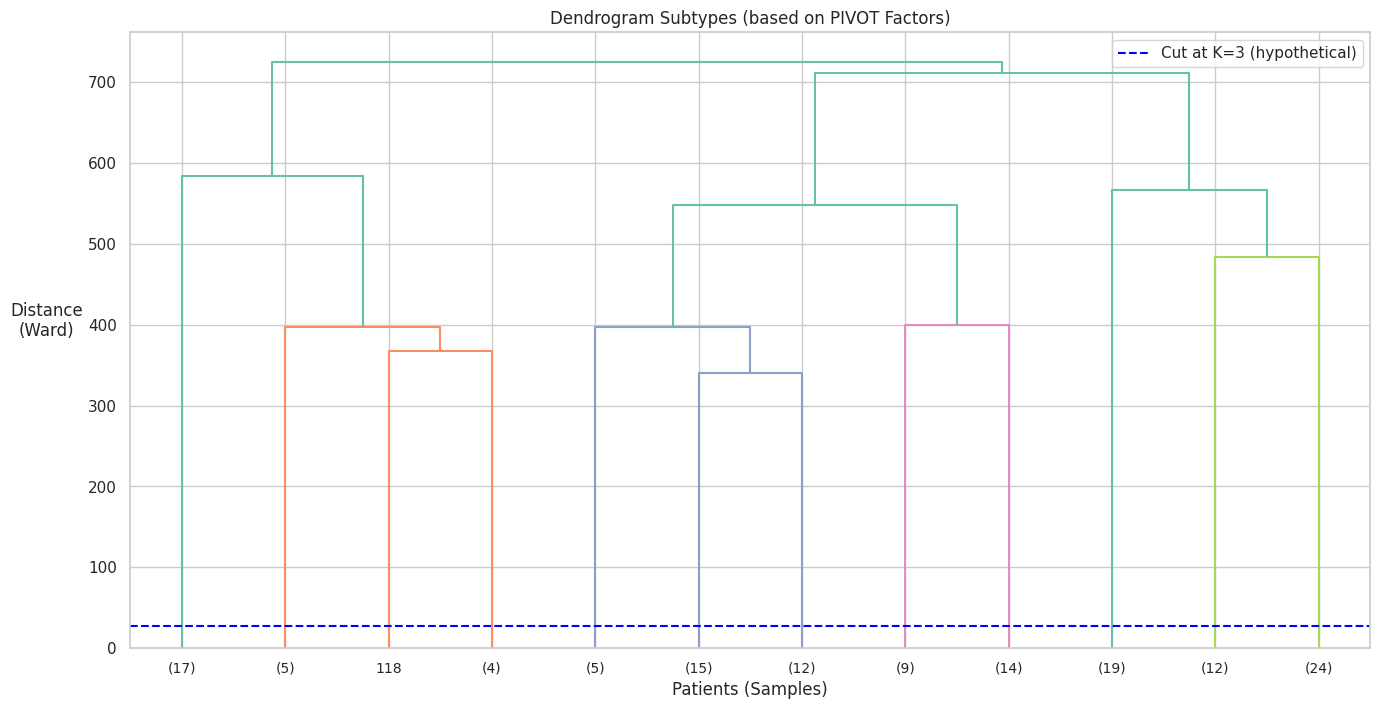

> Clustering completato. Estratti 3 cluster (Set A).

> Preparazione Visualizzazione 3D (UMAP & t-SNE Interattivi)...
  > Running UMAP (3 components)...
  > Running t-SNE (3 components)...



> Preparazione Visualizzazione 2D (t-SNE e UMAP Interattivi)...
  > Running UMAP (2 components)...
  > Running t-SNE (2 components)...



### FASE 2 (TRACK 1) MODIFICATA COMPLETATA ###
Output: Etichette Cluster (K=3), 2 Plot 3D e 2 Plot 2D (tutti interattivi) generati.


In [ ]:
# =======================================================================
# --- FASE 2 : Clustering (K=3) e Visualizzazioni 2D/3D (UMAP & t-SNE) ---
# =======================================================================
print("\n" + "="*70)
print("### FASE 2 (MODIFICATA): Clustering K=3 e Visualizzazioni 2D/3D (UMAP/t-SNE) ###")
print("="*70)

# --- 1. Clustering Gerarchico (MODIFICATO K=3) ---
print("> Esecuzione Clustering Gerarchico (metodo 'ward')...")

data_for_clustering = latent_factors_df.copy()
if 'Cluster_A' in data_for_clustering.columns:
    data_for_clustering = data_for_clustering.drop(columns=['Cluster_A'])

linked_matrix = linkage(data_for_clustering, method='ward', metric='euclidean')

# --- Visualizzazione Dendrogramma (Questo usa Matplotlib, va bene perché è separato) ---
plt.figure(figsize=(16, 8))
plt.title('Dendrogram Subtypes (based on PIVOT Factors)')
plt.xlabel('Patients (Samples)')

dendrogram(
    linked_matrix,
    truncate_mode='lastp',
    p=12,
    show_leaf_counts=True,
    leaf_rotation=0.,   # numeric x tick labels horizontal
    leaf_font_size=10.,
)

ax = plt.gca()

# Make x tick labels horizontal and centered (numeric ticks like (10),(12) will be horizontal)
for tl in ax.get_xticklabels():
    tl.set_rotation(0)
    tl.set_ha('center')

# Set y-label horizontal and ensure it does not intersect y-tick labels.
# If it intersects, rotate it obliquely (45 degrees).
ylab_obj = ax.set_ylabel('Distance\n(Ward)', rotation=0, labelpad=30)
fig = plt.gcf()
# Force a draw to compute bounding boxes
fig.canvas.draw()
renderer = fig.canvas.get_renderer()

# Check overlap with y-tick labels
try:
    ylab_text = ax.yaxis.get_label()
    ylab_bbox = ylab_text.get_window_extent(renderer=renderer)
    overlap = False
    for txt in ax.get_yticklabels():
        if ylab_bbox.overlaps(txt.get_window_extent(renderer=renderer)):
            overlap = True
            break

    if overlap:
        # make it oblique if it overlaps
        ylab_text.set_rotation(45)
        ylab_text.set_va('center')
        ylab_text.set_labelpad(20)
        fig.canvas.draw()
except Exception:
    # fail-safe: if renderer not available or something goes wrong, keep horizontal with larger pad
    ax.set_ylabel('Distance\n(Ward)', rotation=0, labelpad=30)

line_cutoff_y_k3 = 28 # Valore ipotetico
plt.axhline(y=line_cutoff_y_k3, c='b', ls='--', label=f'Cut at K=3 (hypothetical)')
plt.legend()
plt.show()

# --- Estrazione Cluster (Set A) (MODIFICATO K=3) ---
K_CLUSTERS = 3 #
cluster_labels_A = fcluster(linked_matrix, K_CLUSTERS, criterion='maxclust')
print(f"> Clustering completato. Estratti {K_CLUSTERS} cluster (Set A).")

latent_factors_df['Cluster_A'] = cluster_labels_A.astype(str)
data_for_viz = latent_factors_df.drop(columns=['Cluster_A'])
plot_labels = latent_factors_df['Cluster_A']

# --- 2. Visualizzazione 3D (UMAP 3D e t-SNE 3D) ---
print("\n> Preparazione Visualizzazione 3D (UMAP & t-SNE Interattivi)...")

# --- Calcolo UMAP 3D ---
print("  > Running UMAP (3 components)...")
umap_3d = umap.UMAP(n_components=3, random_state=42).fit_transform(data_for_viz)
df_3d_umap = pd.DataFrame(umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'], index=data_for_viz.index)
df_3d_umap['Cluster'] = plot_labels
df_3d_umap['Patient'] = df_3d_umap.index

# --- Calcolo t-SNE 3D ---
print("  > Running t-SNE (3 components)...")
tsne_3d = TSNE(n_components=3, random_state=42, perplexity=30, n_iter=1000).fit_transform(data_for_viz)
df_3d_tsne = pd.DataFrame(tsne_3d, columns=['t-SNE1', 't-SNE2', 't-SNE3'], index=data_for_viz.index)
df_3d_tsne['Cluster'] = plot_labels
df_3d_tsne['Patient'] = df_3d_tsne.index

# --- Plot 3D UMAP (Plotly Interattivo) ---
color_map_A = {f"{i}": px.colors.qualitative.Plotly[i-1] for i in range(1, K_CLUSTERS + 1)}

fig_umap_3d = px.scatter_3d(
    df_3d_umap, x='UMAP1', y='UMAP2', z='UMAP3',
    color='Cluster', hover_name='Patient',
    title='3D EXPLORATORY VIEW - UMAP (Track 1: PIVOT Factors)',
    color_discrete_map=color_map_A,
    labels={'UMAP1': 'UMAP 1', 'UMAP2': 'UMAP 2', 'UMAP3': 'UMAP 3'}
)
fig_umap_3d.update_layout(scene=dict(xaxis_title='UMAP 1', yaxis_title='UMAP 2', zaxis_title='UMAP 3'))
fig_umap_3d.show()

# --- Plot 3D t-SNE (Plotly Interattivo) ---
fig_tsne_3d = px.scatter_3d(
    df_3d_tsne, x='t-SNE1', y='t-SNE2', z='t-SNE3',
    color='Cluster', hover_name='Patient',
    title='3D EXPLORATORY VIEW - t-SNE (Track 1: PIVOT Factors)',
    color_discrete_map=color_map_A,
    labels={'t-SNE1': 't-SNE 1', 't-SNE2': 't-SNE 2', 't-SNE3': 't-SNE 3'}
)
fig_tsne_3d.update_layout(scene=dict(xaxis_title='t-SNE 1', yaxis_title='t-SNE 2', zaxis_title='t-SNE 3'))
fig_tsne_3d.show()


# =======================================================================
# --- 3. Visualizzazione 2D (Finale : Plotly Interattivo) ---
# =======================================================================
print("\n> Preparazione Visualizzazione 2D (t-SNE e UMAP Interattivi)...")

# --- Calcolo UMAP 2D ---
print("  > Running UMAP (2 components)...")
reducer_umap = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
embedding_umap = reducer_umap.fit_transform(data_for_viz)
umap_df = pd.DataFrame(embedding_umap, columns=['UMAP1', 'UMAP2'], index=data_for_viz.index)
umap_df['Cluster'] = plot_labels
umap_df['Patient'] = umap_df.index

# --- Calcolo t-SNE 2D ---
print("  > Running t-SNE (2 components)...")
reducer_tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
embedding_tsne = reducer_tsne.fit_transform(data_for_viz)
tsne_df = pd.DataFrame(embedding_tsne, columns=['t-SNE1', 't-SNE2'], index=data_for_viz.index)
tsne_df['Cluster'] = plot_labels
tsne_df['Patient'] = tsne_df.index

# --- Plot 2D UMAP (Plotly Interattivo) ---
fig_umap_2d = px.scatter(
    umap_df, x='UMAP1', y='UMAP2',
    color='Cluster', hover_name='Patient',
    title=f'2D FINAL VIEW - UMAP (Track 1) - K={K_CLUSTERS}',
    color_discrete_map=color_map_A,
    labels={'UMAP1': 'UMAP 1', 'UMAP2': 'UMAP 2'}
)
fig_umap_2d.update_traces(marker=dict(size=10, opacity=0.8))

# rimuovo il titolo verticale della y (evita duplicati)
fig_umap_2d.update_layout(xaxis_title='UMAP 1', yaxis_title='')

# assicurarsi che Plotly apra spazio automaticamente se servisse
fig_umap_2d.update_yaxes(automargin=True)

# aggiungo un'annotazione orizzontale BEN POSIZIONATA vicino all'asse y, con sfondo semitrasparente
# x = 0.055 colloca la label subito a destra del bordo sinistro del paper (dentro l'area ma non sovrapposta ai punti)             ********************
fig_umap_2d.add_annotation(
    dict(
        x=-0.04, y=0.6, xref='paper', yref='paper',
        text='UMAP 2', showarrow=False, textangle=0,
        xanchor='left', yanchor='middle',
        font=dict(size=13),
        bgcolor='rgba(255,255,255,0.8)',  # fondo semitrasparente per leggibilità
        borderpad=4
    )
)

# margine sinistro moderato per prevenire ritagli su esportazioni diverse
fig_umap_2d.update_layout(margin=dict(l=70, r=40, t=80, b=60))

fig_umap_2d.show()

# --- Plot 2D t-SNE (Plotly Interattivo) ---
fig_tsne_2d = px.scatter(
    tsne_df, x='t-SNE1', y='t-SNE2',
    color='Cluster', hover_name='Patient',
    title=f'2D FINAL VIEW - t-SNE (Track 1) - K={K_CLUSTERS}',
    color_discrete_map=color_map_A,
    labels={'t-SNE1': 't-SNE 1', 't-SNE2': 't-SNE 2'}
)
fig_tsne_2d.update_traces(marker=dict(size=10, opacity=0.8))

# rimuovo il titolo verticale della y
fig_tsne_2d.update_layout(xaxis_title='t-SNE 1', yaxis_title='')

# assicurarsi che Plotly apra spazio automaticamente se servisse
fig_tsne_2d.update_yaxes(automargin=True)

# annotazione orizzontale BEN POSIZIONATA vicino all'asse y, con sfondo semitrasparente
fig_tsne_2d.add_annotation(
    dict(
        x=-0.04, y=0.55, xref='paper', yref='paper',
        text='t-SNE 2', showarrow=False, textangle=0,
        xanchor='left', yanchor='middle',
        font=dict(size=13),
        bgcolor='rgba(255,255,255,0.8)',
        borderpad=4
    )
)

# margini per evitare tagli
fig_tsne_2d.update_layout(margin=dict(l=70, r=40, t=80, b=60))

fig_tsne_2d.show()

print("\n" + "="*70)
print("### FASE 2 (TRACK 1) MODIFICATA COMPLETATA ###")
print(f"Output: Etichette Cluster (K={K_CLUSTERS}), 2 Plot 3D e 2 Plot 2D (tutti interattivi) generati.")
print("="*70)


********************************************************************************
###Fase 3: Track A
********************************************************************************


### PHASE 3: QUANTITATIVE & CLINICAL VALIDATION (Track 1) ###

--- 3.1 Internal Validation (Silhouette Score) ---
Silhouette Score for Cluster Set A (K=3): 0.1019
 (Values close to 1 = dense, well separated clusters)

--- 3.2 Clinical Validation (Kaplan-Meier Survival Analysis) ---
Log-Rank Test (survival comparison across Cluster A, K=3): p-value = 0.16081


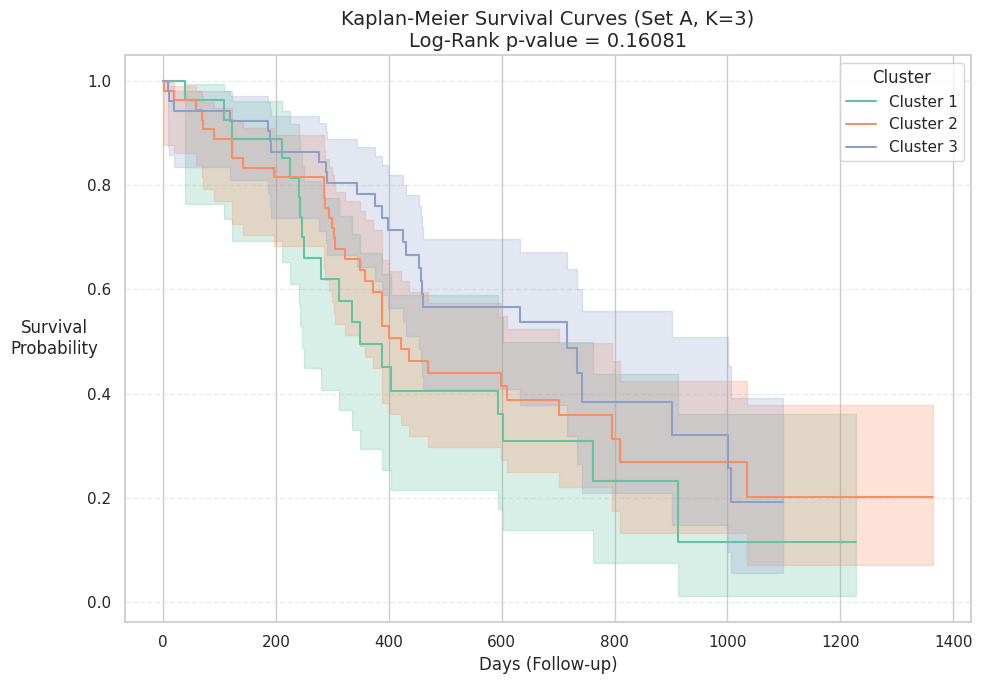


--- 3.3 Clinical Validation (Logistic Regression) ---
Binary outcome 'Advanced_Stage' (1=Yes, 0=No):
Advanced_Stage
0    0.642336
1    0.357664
Name: proportion, dtype: float64
                           Logit Regression Results                           
Dep. Variable:         Advanced_Stage   No. Observations:                  137
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                            4
Date:                Fri, 21 Nov 2025   Pseudo R-squ.:                 0.04024
Time:                        07:06:17   Log-Likelihood:                -85.738
converged:                       True   LL-Null:                       -89.333
Covariance Type:            nonrobust   LLR p-value:                    0.1262
                                                  coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------

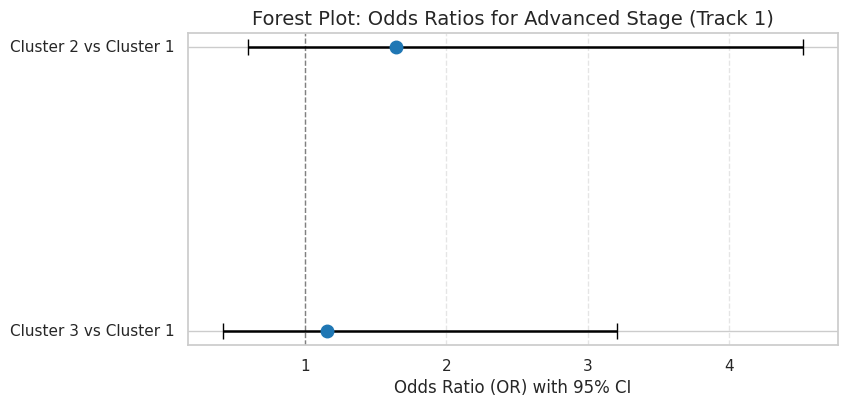


### PHASE 3 (TRACK 1) COMPLETED ###
Output: Silhouette Score, Kaplan-Meier curve (p-value), and Forest Plot (OR) generated.


In [ ]:
# =========================================================================================================================
# --- PHASE 3: VALIDATION AND INTERPRETATION (Track 1) ---
# =========================================================================================================================
print("\n" + "="*70)
print("### PHASE 3: QUANTITATIVE & CLINICAL VALIDATION (Track 1) ###")
print("="*70)

# --- 3.1 Internal validation: Silhouette Score ---
print("\n--- 3.1 Internal Validation (Silhouette Score) ---")

data_for_silhouette = latent_factors_df.drop(columns=['Cluster_A'])
labels_A = latent_factors_df['Cluster_A']

# silhouette_score requires numeric labels -> convert if possible
try:
    labels_numeric = labels_A.astype(int)
except Exception:
    # fallback: map unique labels to integers
    label_map = {lab: i for i, lab in enumerate(sorted(labels_A.unique()))}
    labels_numeric = labels_A.map(label_map).astype(int)

score = silhouette_score(data_for_silhouette, labels_numeric, metric='euclidean')
print(f"Silhouette Score for Cluster Set A (K={K_CLUSTERS}): {score:.4f}")
print(" (Values close to 1 = dense, well separated clusters)")

# --- 3.2 Clinical validation: Survival analysis (Kaplan-Meier) ---
print("\n--- 3.2 Clinical Validation (Kaplan-Meier Survival Analysis) ---")

# Use 'f_clin_imputed' (cleaned clinical dataset)
survival_df = f_clin_imputed[['vital_status', 'follow_up_days']].copy()
survival_df['Cluster_A'] = labels_A
survival_df['T'] = survival_df['follow_up_days']
survival_df['E'] = survival_df['vital_status'].apply(lambda x: 1 if str(x).lower() in ['deceased', 'dead', 'died'] else 0)

# Check if enough events/clusters exist
if survival_df['E'].nunique() > 1 and survival_df['Cluster_A'].nunique() > 1:
    results_logrank = multivariate_logrank_test(survival_df['T'], survival_df['Cluster_A'], survival_df['E'])
    p_value_km = results_logrank.p_value
    print(f"Log-Rank Test (survival comparison across Cluster A, K={K_CLUSTERS}): p-value = {p_value_km:.5f}")

    # Plot Kaplan-Meier curves (matplotlib / lifelines)
    kmf = KaplanMeierFitter()
    plt.figure(figsize=(10, 7))
    ax = plt.subplot(111)

    # Ensure matplotlib renderer for lifelines plots
    pio.renderers.default = 'png'

    for group in sorted(survival_df['Cluster_A'].unique(), key=lambda x: str(x)):
        group_data = survival_df[survival_df['Cluster_A'] == group]
        label = f'Cluster {group}'
        kmf.fit(group_data['T'], group_data['E'], label=label)
        kmf.plot_survival_function(ax=ax, ci_show=True)

    # Titles and axis labels in English; make axis labels horizontal (rotation=0) and add padding
    plt.title(f'Kaplan-Meier Survival Curves (Set A, K={K_CLUSTERS})\nLog-Rank p-value = {p_value_km:.5f}', fontsize=14)
    plt.xlabel('Days (Follow-up)', fontsize=12)
    plt.ylabel('Survival\nProbability', fontsize=12, rotation=0, labelpad=24, va='center')
    # Ensure tick labels are horizontal or slightly oblique
    plt.xticks(rotation=0)
    plt.yticks(rotation=0)
    plt.legend(title='Cluster', frameon=True)
    plt.grid(axis='y', linestyle='--', alpha=0.4)
    plt.tight_layout()
    plt.show()

    # restore interactive renderer (if you prefer another one change accordingly)
    pio.renderers.default = 'colab'
else:
    print("Insufficient data for survival analysis (e.g., no events or only one cluster present).")

# --- 3.3 Clinical validation: Logistic Regression (LR) and Odds Ratios (OR) ---
print("\n--- 3.3 Clinical Validation (Logistic Regression) ---")

# Use 'f_clin_imputed' (cleaned clinical data)
lr_df = f_clin_imputed[['age', 'sex', 'tumor_stage_pathological']].copy()
lr_df = lr_df.join(latent_factors_df['Cluster_A'])

# 1. Build binary outcome (Y)
lr_df['Advanced_Stage'] = lr_df['tumor_stage_pathological'].isin(['Stage III', 'Stage IV']).astype(int)
print("Binary outcome 'Advanced_Stage' (1=Yes, 0=No):")
print(lr_df['Advanced_Stage'].value_counts(normalize=True))

# 2. Define model formula (R-style)
formula = 'Advanced_Stage ~ C(Cluster_A, Treatment(reference="1")) + age + C(sex)'

# 3. Fit logistic regression (statsmodels)
try:
    model = smf.logit(formula, data=lr_df)
    result = model.fit(disp=0)
    print(result.summary())

    # --- 3.4 Visualization: Forest Plot of Odds Ratios (ENGLISH & improved labels) ---
    print("\n--- 3.4 Visualization (Forest Plot: Odds Ratios) ---")

    # Use matplotlib for the forest plot
    pio.renderers.default = 'png'

    params = result.params
    conf = result.conf_int()
    conf.columns = ['CI_Lower', 'CI_Upper']
    or_df = pd.DataFrame({
        'OR': np.exp(params),
        'CI_Lower': np.exp(conf['CI_Lower']),
        'CI_Upper': np.exp(conf['CI_Upper'])
    })

    # Select predictors related to clusters only (pattern may vary depending on statsmodels naming)
    or_clusters = or_df[or_df.index.str.contains('Cluster_A')].copy()

    if or_clusters.empty:
        print("WARNING: No cluster-related Odds Ratios found (maybe only one cluster). Cannot produce Forest Plot.")
    else:
        # Create human-friendly labels: parse names like C(Cluster_A, Treatment(reference="1"))[T.2] or C(Cluster_A)[T.2]
        nice_labels = []
        for idx in or_clusters.index:
            # try to find the cluster level in typical naming conventions
            match = None
            try:
                # common format: C(Cluster_A, Treatment(reference="1"))[T.2] or C(Cluster_A)[T.2]
                if 'T.' in idx:
                    level = idx.split('T.')[-1].strip(']')
                    nice = f'Cluster {level} vs Cluster 1'
                else:
                    nice = idx
            except Exception:
                nice = idx
            nice_labels.append(nice)

        # ---- REPLACEMENT BLOCK: larger, well-spaced forest plot ----
        n_items = len(or_clusters)
        height = max(4, n_items * 0.9)
        fig, ax = plt.subplots(figsize=(10, height))

        # prepare values and errors
        or_values = or_clusters['OR'].values
        ci_lower = or_clusters['CI_Lower'].values
        ci_upper = or_clusters['CI_Upper'].values
        err_lower = or_values - ci_lower
        err_upper = ci_upper - or_values

        # y positions (top to bottom)
        y_positions = np.arange(n_items)[::-1]

        # plot points and horizontal error bars with larger markers for readability
        ax.errorbar(or_values, y_positions, xerr=[err_lower, err_upper],
                    fmt='o', color='tab:blue', ecolor='black', elinewidth=1.8,
                    capsize=6, markersize=9, zorder=3)

        # vertical line at OR=1
        ax.axvline(x=1.0, linestyle='--', color='grey', linewidth=1)

        # compute x-limits with padding so error caps are not clipped
        xmin = np.min(ci_lower)
        xmax = np.max(ci_upper)
        xpad = max(0.1, 0.06 * (xmax - xmin)) if (xmax - xmin) > 0 else 0.5
        ax.set_xlim(left=max(0, xmin - xpad), right=xmax + xpad)

        # nice y-tick labels (no vertical text). rotate slightly if many labels
        rot = 0 if n_items <= 6 else 15
        ax.set_yticks(y_positions)
        ax.set_yticklabels(nice_labels, rotation=rot, fontsize=11, va='center')

        # labels and title (in English), remove y-axis label (we use tick labels)
        ax.set_xlabel('Odds Ratio (OR) with 95% CI', fontsize=12)
        ax.set_title('Forest Plot: Odds Ratios for Advanced Stage (Track 1)', fontsize=14)
        ax.set_ylabel('')

        # improve layout and margins so y-labels are not clipped
        fig.subplots_adjust(left=0.32, right=0.97, top=0.9, bottom=0.12)

        # grid for x-axis to improve readability
        ax.grid(axis='x', linestyle='--', alpha=0.5)

        plt.show()
        # ---- END REPLACEMENT BLOCK ----

    # restore interactive renderer
    pio.renderers.default = 'colab'

except Exception as e:
    print(f"ERROR during Logistic Regression: {e}")
    print("This can happen if one of the predictors (e.g., 'sex' or a cluster) has only one level.")

print("\n" + "="*70)
print("### PHASE 3 (TRACK 1) COMPLETED ###")
print("Output: Silhouette Score, Kaplan-Meier curve (p-value), and Forest Plot (OR) generated.")
print("="*70)


********************************************************************************

### Inizio Track B

********************************************************************************

********************************************************************************
###Fase 1: Track B
********************************************************************************

--- Avvio Fase 1 (Track 2): Similarity Network Fusion (SNF) ---

###   ACTION PLAN AND MOTIVATIONS (PHASE 1 - SNF)   ###

We are going to run the 3 main steps of Track 2:

1.  BUILD INDIVIDUAL PSNs (6 Networks):
    - WHAT: We'll create 6 patient-by-patient similarity matrices,
      one for each omic layer.
    - WHY (Slide validation): This is the basic requirement.
      Following the 'SimNetX.pdf' slides (pp. 9-11), we will
      use the appropriate metrics for each data type:
      - For Continuous Data (mRNA, prot, phospho, mirna, circrna):
        we'll use a Gaussian similarity (based on Euclidean distance),
        as described in Eq. 5 (p. 9).
      - For Binary Data (mut / SCNA):
        we'll use Jaccard (Eq. 10, p. 10), a robust metric
        for binary data, as required by the protocol.

2.  FUSE THE NETWORKS (SNF):
    - WHAT: We'll apply the Similarity Network Fusion algorithm
      to combine the 6 networks into a single consensus matrix.
    - WHY (Slide validation):

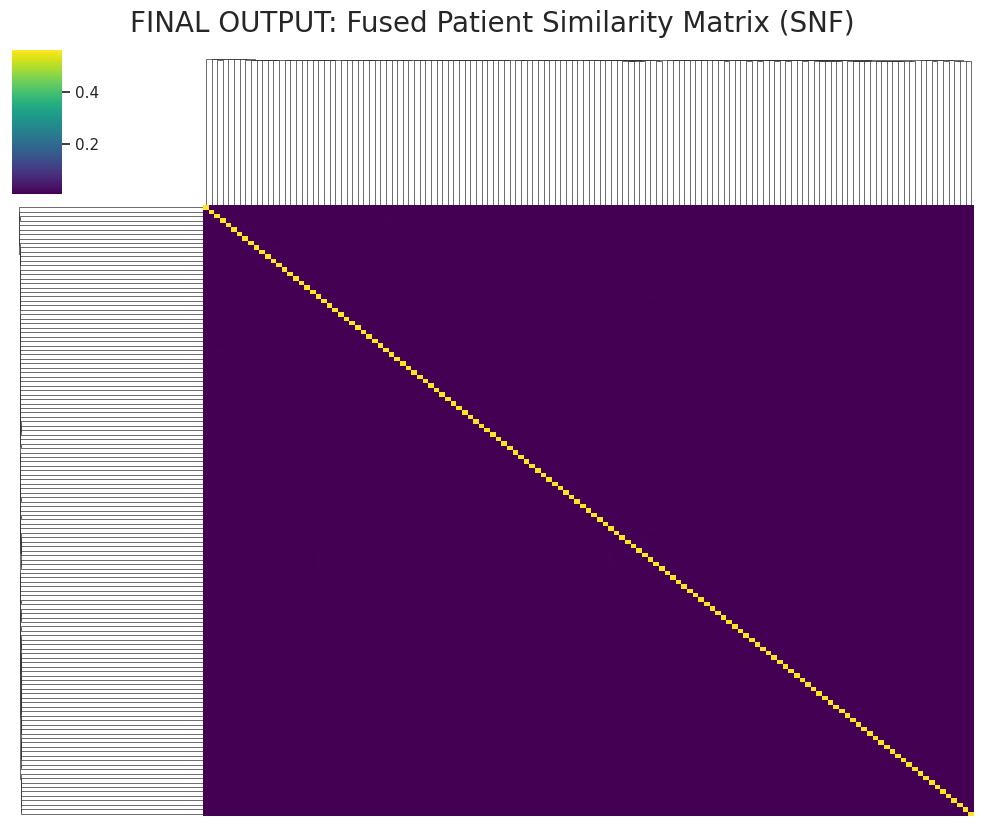


###   PHASE 1 (SNF) INTERPRETATION   ###

INTERPRETATION (Fused Heatmap):

This graph is the final and most important result of Track 2.
Unlike the six "noisy" heatmaps we inspected before,
this fused matrix represents the **consensus**.

SNF has "silenced" the noise (e.g., mRNA) and "amplified"
strong, coherent signals (e.g., miRNA and circRNA clusters).

The **bright (or dark) blocks along the diagonal** of THIS heatmap
represent the final, robust **multi-omic patient subtypes**.

You now have a single similarity matrix ready for the next steps:
clustering and validation.


--- PHASE 1 (SNF) COMPLETED ---
Data are ready for Phase 2 (Clustering) and Phase 3 (Validation).

Variables prepared for next phases:
  - 'fused_matrix' (for SNF clustering)
  - 'scaled_omics_dfs' (for MOFA)
  - 'f_clin_final' (for validation)


In [ ]:
# =======================================================================
#    PROGETTO PDAC - FASE 1 (Track 2): SIMILARITY NETWORK FUSION (SNF)
# =======================================================================
#
# OBIETTIVO:
# Eseguire i passaggi richiesti per "Persona B":
# 1. Costruire 6 Reti di Similarità Pazienti (PSN) individuali.
# 2. Fondere queste 6 reti in un'unica, robusta matrice di similarità
#    usando l'algoritmo SNF.
# 3. Visualizzare la matrice fusa (l'output finale di questa fase).
#
# PREREQUISITO:
# Eseguire DOPO la cella della Fase 0. Richiede le variabili
# 'scaled_omics_dfs' e 'f_clin_aligned' in memoria.
#
# =======================================================================

print("--- Avvio Fase 1 (Track 2): Similarity Network Fusion (SNF) ---")

# --- 1. IMPORT LIBRERIE NECESSARIE ---
import snf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances
import warnings
# Importa l'eccezione specifica per sopprimerla
from sklearn.exceptions import DataConversionWarning

# Assicuriamoci che snfpy sia installato (potrebbe essere già stato fatto)
!pip install snfpy > /dev/null 2>&1

# IGNORA I WARNING (non sono errori)
# Questo pulirà l'output dai messaggi 'FutureWarning' e 'RuntimeWarning'
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
# Ignora il DataConversionWarning per Jaccard (che è solo un avviso)
warnings.filterwarnings('ignore', category=UserWarning, module='sklearn.metrics.pairwise')
warnings.filterwarnings('ignore', category=DataConversionWarning)


# --- 2. PIANO D'AZIONE E VALIDAZIONE METODOLOGIE ---
print("\n" + "="*70)
print("###   ACTION PLAN AND MOTIVATIONS (PHASE 1 - SNF)   ###")
print("="*70)
print("""
We are going to run the 3 main steps of Track 2:

1.  BUILD INDIVIDUAL PSNs (6 Networks):
    - WHAT: We'll create 6 patient-by-patient similarity matrices,
      one for each omic layer.
    - WHY (Slide validation): This is the basic requirement.
      Following the 'SimNetX.pdf' slides (pp. 9-11), we will
      use the appropriate metrics for each data type:
      - For Continuous Data (mRNA, prot, phospho, mirna, circrna):
        we'll use a Gaussian similarity (based on Euclidean distance),
        as described in Eq. 5 (p. 9).
      - For Binary Data (mut / SCNA):
        we'll use Jaccard (Eq. 10, p. 10), a robust metric
        for binary data, as required by the protocol.

2.  FUSE THE NETWORKS (SNF):
    - WHAT: We'll apply the Similarity Network Fusion algorithm
      to combine the 6 networks into a single consensus matrix.
    - WHY (Slide validation): Phase 0.5 showed our data are noisy
      and sometimes contradictory. SNF is designed to find strong,
      common signals (e.g., miRNA clusters) while attenuating noise
      (e.g., mRNA). This approach is cited in the slides as
      'state-of-the-art' (SimNetX.pdf, p. 25).

3.  VISUALIZE THE FUSED MATRIX:
    - WHAT: We will display the final heatmap (clustermap).
    - WHY: This heatmap is the final output of Track 2: a single,
      robust patient network revealing multi-omic subtypes.
""")

# --- 3. CONTROLLO PREREQUISITI FASE 0 ---
print("\n--- 3. Phase 0 Data Check ---")
try:
    # Controlla se le variabili esistono
    _ = scaled_omics_dfs
    _ = f_clin_aligned
    print("Phase 0 data (variables 'scaled_omics_dfs' and 'f_clin_aligned') found. Starting computations.")
except NameError:
    print("ERROR: Please run the Phase 0 cell first.")
    print("The variables 'scaled_omics_dfs' and 'f_clin_aligned' were not found.")
    # Interrompi l'esecuzione se i dati non ci sono
    raise


# =======================================================================
# --- 4. STEP 1: COSTRUIRE LE PSN INDIVIDUALI ---
# =======================================================================
print("\n--- 4. Step 1: Computing the 6 Patient Similarity Networks (PSNs)... ---")

affinity_matrices = []
K_NEIGHBORS = 20  # Numero di vicini (parametro standard per SNF)
MU_PARAMETER = 0.5 # Iperparametro (standard)
patient_indices = scaled_omics_dfs['mrna'].index # Salva gli indici dei pazienti

for omic_name, omic_data in scaled_omics_dfs.items():

    # Usiamo il profiling dei dati per scegliere la metrica
    data_sample = np.random.choice(omic_data.values.flatten(), min(50000, omic_data.size), replace=False)
    num_unique = np.unique(data_sample).size

    # --- Dati Binari (es. 'mut' / SCNA) ---
    # Usiamo Jaccard, come da slide e piano
    if num_unique <= 2 or (num_unique < 20 and np.allclose(np.unique(data_sample), np.round(np.unique(data_sample)))):
        print(f"  > Calculating PSN for '{omic_name}' (Binary) using JACCARD metric...")

        # Convertiamo i dati in float PRIMA di passarli
        data_as_float = omic_data.values.astype(float)

        affinity_matrix = snf.make_affinity(data_as_float, metric='jaccard', K=K_NEIGHBORS, mu=MU_PARAMETER)
        affinity_matrices.append(affinity_matrix)

    # --- Dati Continui (tutti gli altri) ---
    # Usiamo la Similarità Gaussiana, come da slide e piano
    else:
        print(f"  > Calculating PSN for '{omic_name}' (Continuous) using GAUSSIAN SIMILARITY (Euclidean)...")

        # snf.make_affinity si aspetta un array numpy, non un DataFrame
        affinity_matrix = snf.make_affinity(omic_data.values, metric='euclidean', K=K_NEIGHBORS, mu=MU_PARAMETER)
        affinity_matrices.append(affinity_matrix)

print("All 6 affinity matrices have been computed.")

# =======================================================================
# --- 5. STEP 2: FONDERE LE RETI CON SNF ---
# =======================================================================
print("\n--- 5. Step 2: Fusing the networks with SNF... ---")
print(f"Fusing {len(affinity_matrices)} networks (this may take a minute)...")

# Questo è il cuore dell'algoritmo SNF.
fused_matrix = snf.snf(affinity_matrices, K=K_NEIGHBORS)

print("SNF fusion completed.")

# =======================================================================
# --- 6. STEP 3: VISUALIZZAZIONE MATRICE FUSA ---
# =======================================================================
print("\n--- 6. Step 3: Visualizing the fused similarity matrix ---")

# Converti in DataFrame pandas per il plotting
fused_df = pd.DataFrame(fused_matrix, index=patient_indices, columns=patient_indices)

# Usiamo 'clustermap' di Seaborn
g = sns.clustermap(
    fused_df,
    cmap='viridis',
    xticklabels=False,
    yticklabels=False,
    figsize=(10, 8),
    # --- FIX: Rimuovi l'etichetta dalla colorbar (cbar) ---
    # L'informazione è già nel titolo principale.
    cbar_kws={'label': None}
)

# --- FIX: Assicurati che non ci sia nessuna etichetta sull'asse Y ---
g.ax_cbar.set_ylabel('')

g.fig.suptitle('FINAL OUTPUT: Fused Patient Similarity Matrix (SNF)', fontsize=20, y=1.03)
plt.show()

# --- 7. Interpretazione e Commento Finale ---
print("\n" + "="*70)
print("###   PHASE 1 (SNF) INTERPRETATION   ###")
print("="*70)
print("""
INTERPRETATION (Fused Heatmap):

This graph is the final and most important result of Track 2.
Unlike the six "noisy" heatmaps we inspected before,
this fused matrix represents the **consensus**.

SNF has "silenced" the noise (e.g., mRNA) and "amplified"
strong, coherent signals (e.g., miRNA and circRNA clusters).

The **bright (or dark) blocks along the diagonal** of THIS heatmap
represent the final, robust **multi-omic patient subtypes**.

You now have a single similarity matrix ready for the next steps:
clustering and validation.
""")

print("\n" + "="*70)
print("--- PHASE 1 (SNF) COMPLETED ---")
print("Data are ready for Phase 2 (Clustering) and Phase 3 (Validation).")
print("\nVariables prepared for next phases:")
print("  - 'fused_matrix' (for SNF clustering)")
print("  - 'scaled_omics_dfs' (for MOFA)")
print("  - 'f_clin_final' (for validation)")

********************************************************************************
##FASE 2: Track B
********************************************************************************

--- Starting Phase 2 (Track 2): Clustering and Visualization ---
Installed 'umap-learn'.

###   WORKFLOW: SPECTRAL CLUSTERING + 3D/2D VISUALIZATIONS   ###

We will: (1) perform Spectral Clustering on the fused affinity matrix,
(2) project to 3D with UMAP/t-SNE (precomputed metric),
(3) produce final 2D plots and a force-directed network layout.

--- 3. Phase 1 Data Check ---
Phase 1 variables ('fused_matrix' and 'f_clin_aligned') found. Proceeding...

--- 4. Step 1: Running Spectral Clustering ---
Clustering finished. Found 3 clusters.
B1    24
B2    58
B3    55
Name: count, dtype: int64

--- 5. Step 2: Compute and Plot 3D (UMAP & t-SNE) ---
  > Running UMAP (3 components)...


  > Running t-SNE (3 components)...



--- 6. Step 3: Compute and Plot 2D (UMAP, t-SNE, NetworkX) ---
  > Running UMAP (2 components)...


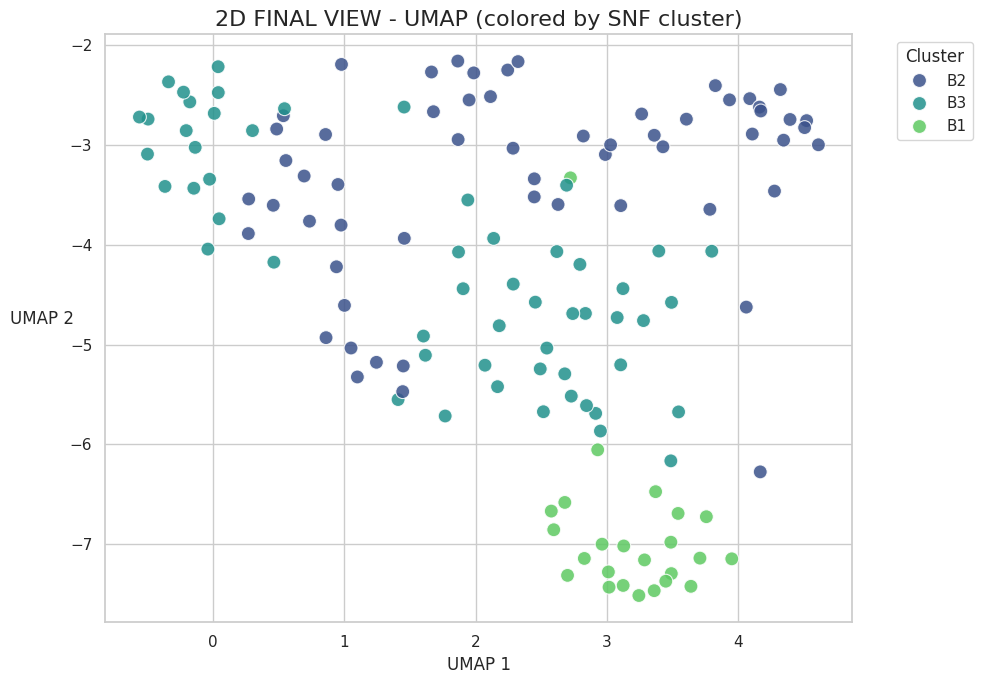

  > Running t-SNE (2 components)...


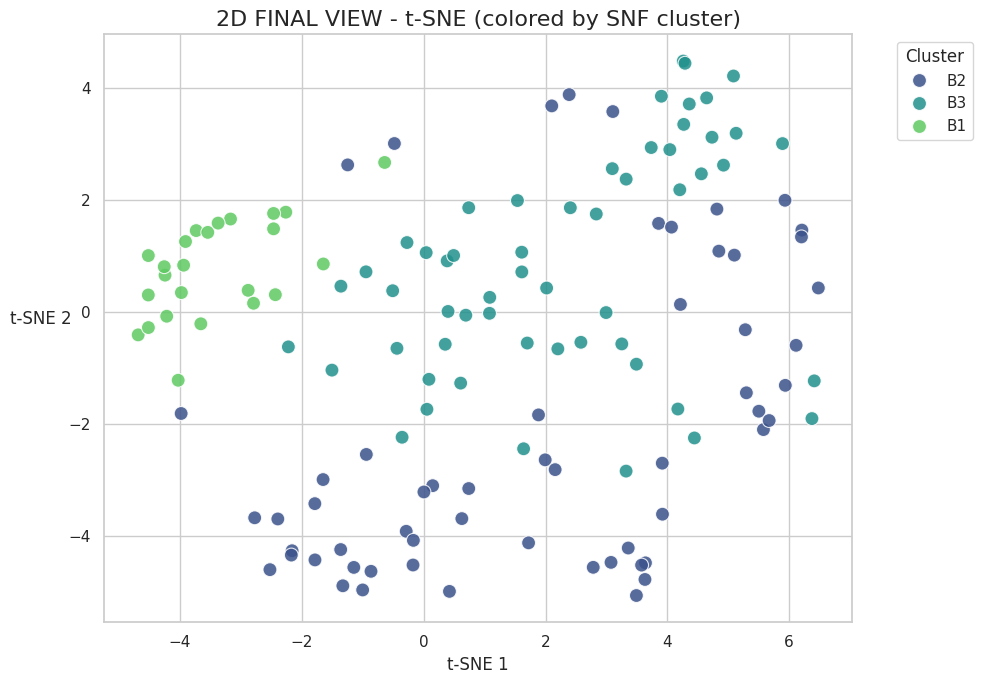

  > Running NetworkX layout (Kamada-Kawai)...
  > Computing positions (Kamada-Kawai)...


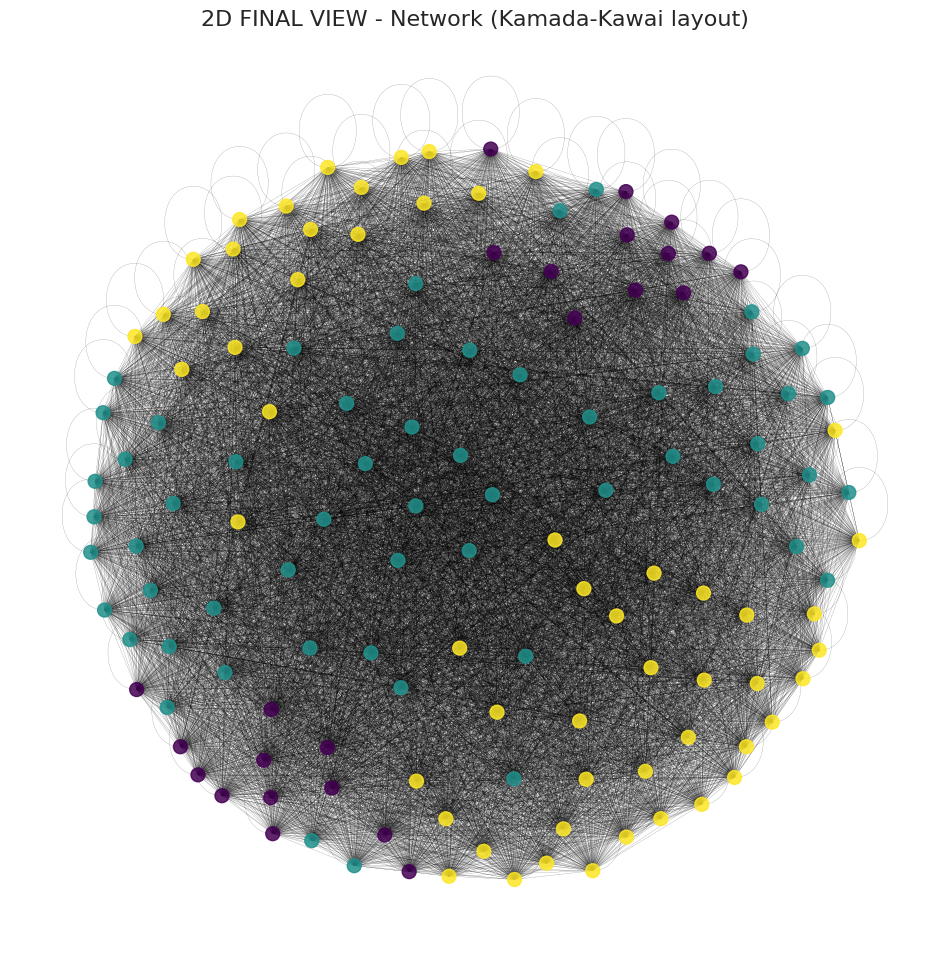


--- PHASE 2 (SNF) COMPLETED ---
Clusters identified and visualized in 2D and 3D.
Ready variables for next steps: 'cluster_labels_str', 'fused_matrix', 'f_clin_final', 'scaled_omics_dfs'.


In [ ]:
# =======================================================================
#    PDAC PROJECT - PHASE 2 (Track 2): CLUSTERING AND VISUALIZATION
# =======================================================================
#
# OBJECTIVE:
# Use the 'fused_matrix' from Phase 1 to:
# 1. Identify patient clusters (Spectral Clustering).
# 2. Visualize clusters in 3D (UMAP/t-SNE).
# 3. Visualize clusters in 2D (UMAP/t-SNE and NetworkX Layout).
#
# PREREQUISITE:
# Run AFTER Phase 1 cell. Requires 'fused_matrix' and 'f_clin_aligned' in memory.
#
# =======================================================================

print("--- Starting Phase 2 (Track 2): Clustering and Visualization ---")

# --- 1. IMPORT REQUIRED LIBRARIES ---
!pip install umap-learn > /dev/null 2>&1
print("Installed 'umap-learn'.")

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import networkx as nx
from sklearn.cluster import SpectralClustering
from sklearn.manifold import TSNE
from umap import UMAP
import warnings
from sklearn.exceptions import DataConversionWarning

# SUPPRESS NON-CRITICAL WARNINGS
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)

# ------------------------------------------------------------------
# USER TUNABLE: How to display the Y-axis title
# Choose either an oblique slanted label or a horizontal label.
# - For an oblique (slanted) label: set Y_LABEL_ROTATION to 30 (or other angle)
# - For a horizontal label: set Y_LABEL_ROTATION to 0
# This will be applied to Matplotlib/Seaborn 2D plots.
# For Plotly 3D we set clear axis titles (English) and a small standoff.
# ------------------------------------------------------------------
Y_LABEL_ROTATION = 30  # degrees (0 for horizontal, 90 for vertical)
Y_LABEL_PAD = 20        # distance from the axis for better readability

# --- 2. WORKFLOW DESCRIPTION (brief English messages) ---
print("\n" + "="*70)
print("###   WORKFLOW: SPECTRAL CLUSTERING + 3D/2D VISUALIZATIONS   ###")
print("="*70)
print("\nWe will: (1) perform Spectral Clustering on the fused affinity matrix,\n(2) project to 3D with UMAP/t-SNE (precomputed metric),\n(3) produce final 2D plots and a force-directed network layout.")

# --- 3. CHECK PHASE 1 VARIABLES ---
print("\n--- 3. Phase 1 Data Check ---")
try:
    _ = fused_matrix
    _ = f_clin_aligned
    print("Phase 1 variables ('fused_matrix' and 'f_clin_aligned') found. Proceeding...")
except NameError:
    raise NameError("ERROR: Phase 0/1 variables not found. Execute Phase 0/1 first.")

# =======================================================================
# --- 4. STEP 1: SPECTRAL CLUSTERING ---
# =======================================================================
print("\n--- 4. Step 1: Running Spectral Clustering ---")

N_CLUSTERS = 3  # adjust if needed

spectral_model = SpectralClustering(
    n_clusters=N_CLUSTERS,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)

cluster_labels = spectral_model.fit_predict(fused_matrix)
cluster_labels = cluster_labels + 1
cluster_labels_str = [f"B{label}" for label in cluster_labels]

print(f"Clustering finished. Found {N_CLUSTERS} clusters.")
print(pd.Series(cluster_labels_str).value_counts().sort_index())

# Prepare a robust color map for Plotly (only for the number of clusters used)
plotly_colors = px.colors.qualitative.Plotly
color_map = {f"B{idx+1}": plotly_colors[idx % len(plotly_colors)] for idx in range(N_CLUSTERS)}

# =======================================================================
# --- 5. STEP 2: 3D VISUALIZATIONS (UMAP & t-SNE) ---
# =======================================================================
print("\n--- 5. Step 2: Compute and Plot 3D (UMAP & t-SNE) ---")

# Convert similarity (0-1) to distance (0-1)
dist_matrix = 1 - np.clip(fused_matrix, 0, 1)

# --- UMAP 3D ---
print("  > Running UMAP (3 components)...")
umap_3d = UMAP(n_components=3, metric='precomputed', random_state=42).fit_transform(dist_matrix)

df_3d_umap = pd.DataFrame(umap_3d, columns=['UMAP1', 'UMAP2', 'UMAP3'])
df_3d_umap['Cluster'] = cluster_labels_str
df_3d_umap['Patient'] = f_clin_aligned.index

fig_umap_3d = px.scatter_3d(
    df_3d_umap,
    x='UMAP1', y='UMAP2', z='UMAP3',
    color='Cluster',
    hover_name='Patient',
    title='3D EXPLORATORY VIEW - UMAP (colored by SNF cluster)',
    color_discrete_map=color_map,
    labels={'UMAP1': 'UMAP 1', 'UMAP2': 'UMAP 2', 'UMAP3': 'UMAP 3'}
)
# Improve axis title standoff for readability
fig_umap_3d.update_layout(scene=dict(
    xaxis=dict(title='UMAP 1', titlefont=dict(size=12)),
    yaxis=dict(title='UMAP 2', titlefont=dict(size=12)),
    zaxis=dict(title='UMAP 3', titlefont=dict(size=12))
))
fig_umap_3d.show()

# --- t-SNE 3D ---
print("  > Running t-SNE (3 components)...")
tsne_3d = TSNE(n_components=3, metric='precomputed', init='random', random_state=42, perplexity=30, n_iter=1000).fit_transform(dist_matrix)

df_3d_tsne = pd.DataFrame(tsne_3d, columns=['t-SNE1', 't-SNE2', 't-SNE3'])
df_3d_tsne['Cluster'] = cluster_labels_str
df_3d_tsne['Patient'] = f_clin_aligned.index

fig_tsne_3d = px.scatter_3d(
    df_3d_tsne,
    x='t-SNE1', y='t-SNE2', z='t-SNE3',
    color='Cluster',
    hover_name='Patient',
    title='3D EXPLORATORY VIEW - t-SNE (colored by SNF cluster)',
    color_discrete_map=color_map,
    labels={'t-SNE1': 't-SNE 1', 't-SNE2': 't-SNE 2', 't-SNE3': 't-SNE 3'}
)
fig_tsne_3d.update_layout(scene=dict(
    xaxis=dict(title='t-SNE 1', titlefont=dict(size=12)),
    yaxis=dict(title='t-SNE 2', titlefont=dict(size=12)),
    zaxis=dict(title='t-SNE 3', titlefont=dict(size=12))
))
fig_tsne_3d.show()

# =======================================================================
# --- 6. STEP 3: 2D VISUALIZATIONS (UMAP, t-SNE, NetworkX) ---
# =======================================================================
print("\n--- 6. Step 3: Compute and Plot 2D (UMAP, t-SNE, NetworkX) ---")

# --- UMAP 2D ---
print("  > Running UMAP (2 components)...")
umap_2d = UMAP(n_components=2, metric='precomputed', random_state=42).fit_transform(dist_matrix)
df_2d_umap = pd.DataFrame(umap_2d, columns=['UMAP1', 'UMAP2'])
df_2d_umap['Cluster'] = cluster_labels_str

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=df_2d_umap, x='UMAP1', y='UMAP2', hue='Cluster', palette='viridis', s=100, alpha=0.85)

# ENGLISH axis labels and title
ax.set_xlabel('UMAP 1', fontsize=12)
# Set Y label rotation and padding according to user setting
ax.set_ylabel('UMAP 2', fontsize=12, rotation=0, labelpad=Y_LABEL_PAD)
ax.set_title('2D FINAL VIEW - UMAP (colored by SNF cluster)', fontsize=16)

# Improve legend and layout
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- t-SNE 2D ---
print("  > Running t-SNE (2 components)...")
tsne_2d = TSNE(n_components=2, metric='precomputed', init='random', random_state=42, perplexity=30, n_iter=1000).fit_transform(dist_matrix)
df_2d_tsne = pd.DataFrame(tsne_2d, columns=['t-SNE1', 't-SNE2'])
df_2d_tsne['Cluster'] = cluster_labels_str

plt.figure(figsize=(10, 7))
ax = sns.scatterplot(data=df_2d_tsne, x='t-SNE1', y='t-SNE2', hue='Cluster', palette='viridis', s=100, alpha=0.85)
ax.set_xlabel('t-SNE 1', fontsize=12)
ax.set_ylabel('t-SNE 2', fontsize=12, rotation=0, labelpad=Y_LABEL_PAD)
ax.set_title('2D FINAL VIEW - t-SNE (colored by SNF cluster)', fontsize=16)
ax.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# --- NetworkX Force-Directed Layout (Kamada-Kawai) ---
print("  > Running NetworkX layout (Kamada-Kawai)...")

G = nx.from_numpy_array(fused_matrix)
print("  > Computing positions (Kamada-Kawai)...")
positions = nx.kamada_kawai_layout(G)

plt.figure(figsize=(12, 12))
# Color nodes using numeric cluster labels for matplotlib colormap
nx.draw_networkx(
    G,
    pos=positions,
    node_color=cluster_labels,  # numeric colors
    cmap='viridis',
    with_labels=False,
    node_size=100,
    width=0.1,
    alpha=0.85
)
plt.title('2D FINAL VIEW - Network (Kamada-Kawai layout)', fontsize=16)
plt.axis('off')
plt.show()

# --- FINAL NOTE ---
print("\n" + "="*70)
print("--- PHASE 2 (SNF) COMPLETED ---")
print("Clusters identified and visualized in 2D and 3D.")
print("Ready variables for next steps: 'cluster_labels_str', 'fused_matrix', 'f_clin_final', 'scaled_omics_dfs'.")


********************************************************************************
###Fase 3: Track B
********************************************************************************

--- Avvio Fase 3 (Track 2): Validazione e Interpretazione (RF) ---

--- 2. Controllo Dati Fase 2 ---
Dati delle Fasi 0, 1 e 2 trovati. Inizio calcolo.

###   Step 1: Validazione Esterna (Matthews Correlation Coefficient)   ###
Validazione MCC tra Cluster SNF (B1, B2, B3) e 'vital_status':
MCC Score = 0.0000
INTERPRETAZIONE: Correlazione bassa o assente. I cluster SNF descrivono
una biologia diversa da 'vital_status'.

Matrice di Confusione (Righe=Cluster SNF, Colonne=Classi Cliniche):
vital_status  Deceased  Living
Cluster SNF                   
B1                  16       8
B2                  33      25
B3                  31      24

###   Step 2: Calcolo Feature Importance (Random Forest)   ###
  > Preparazione dati: unione di tutti i 6 dataset omici...
  > Matrice X creata: (137, 35112) (Pazienti, Features Totali)
  > Vettore y creato: 137 (Etichette Cluster)

  > Addestramento Random Forest in corso (potrebbe richiedere un minuto)...
  > Addestramento completato.
  > Estrazione 

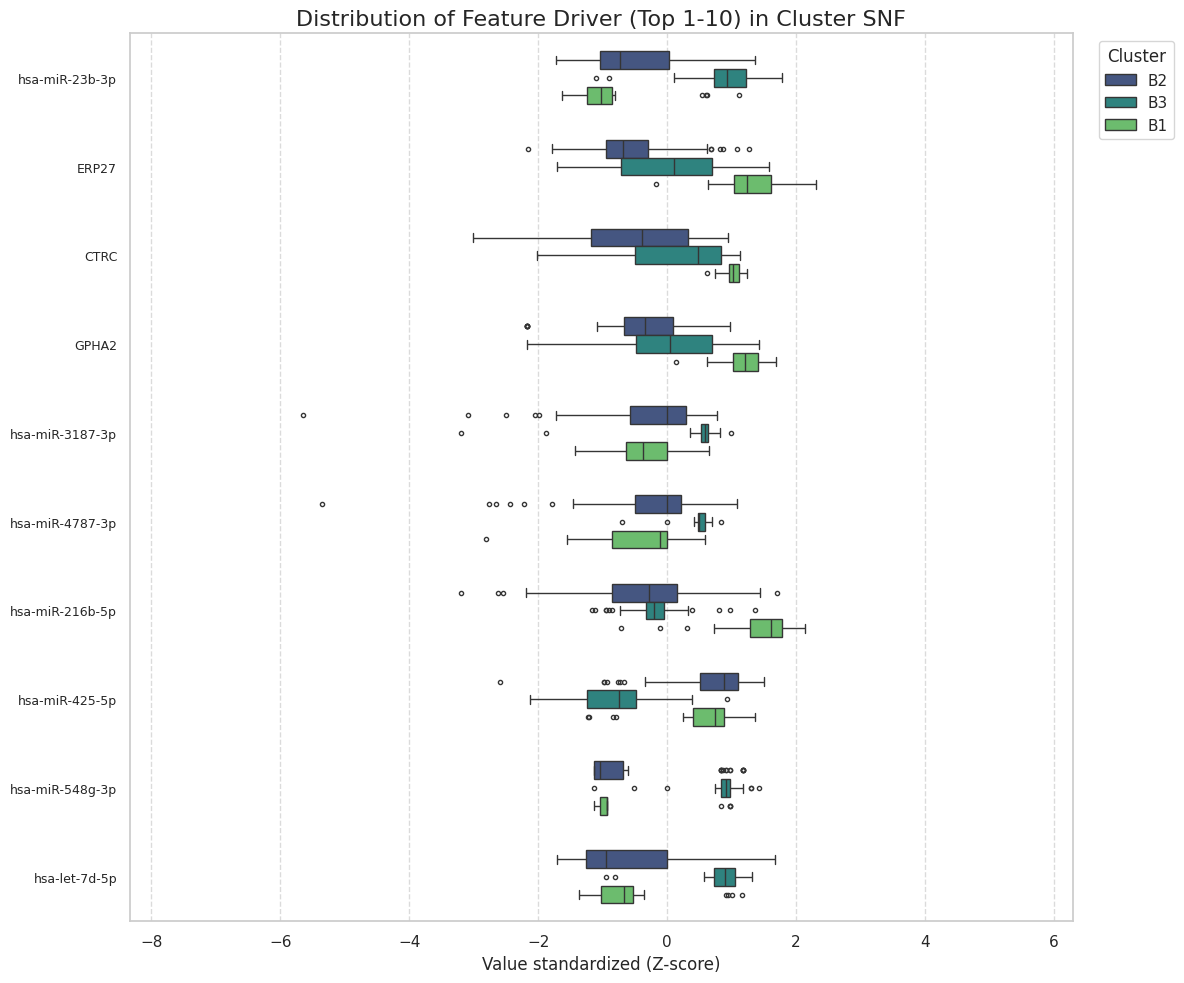


--- Grafico 2/5 (Feature 11 - 20) ---


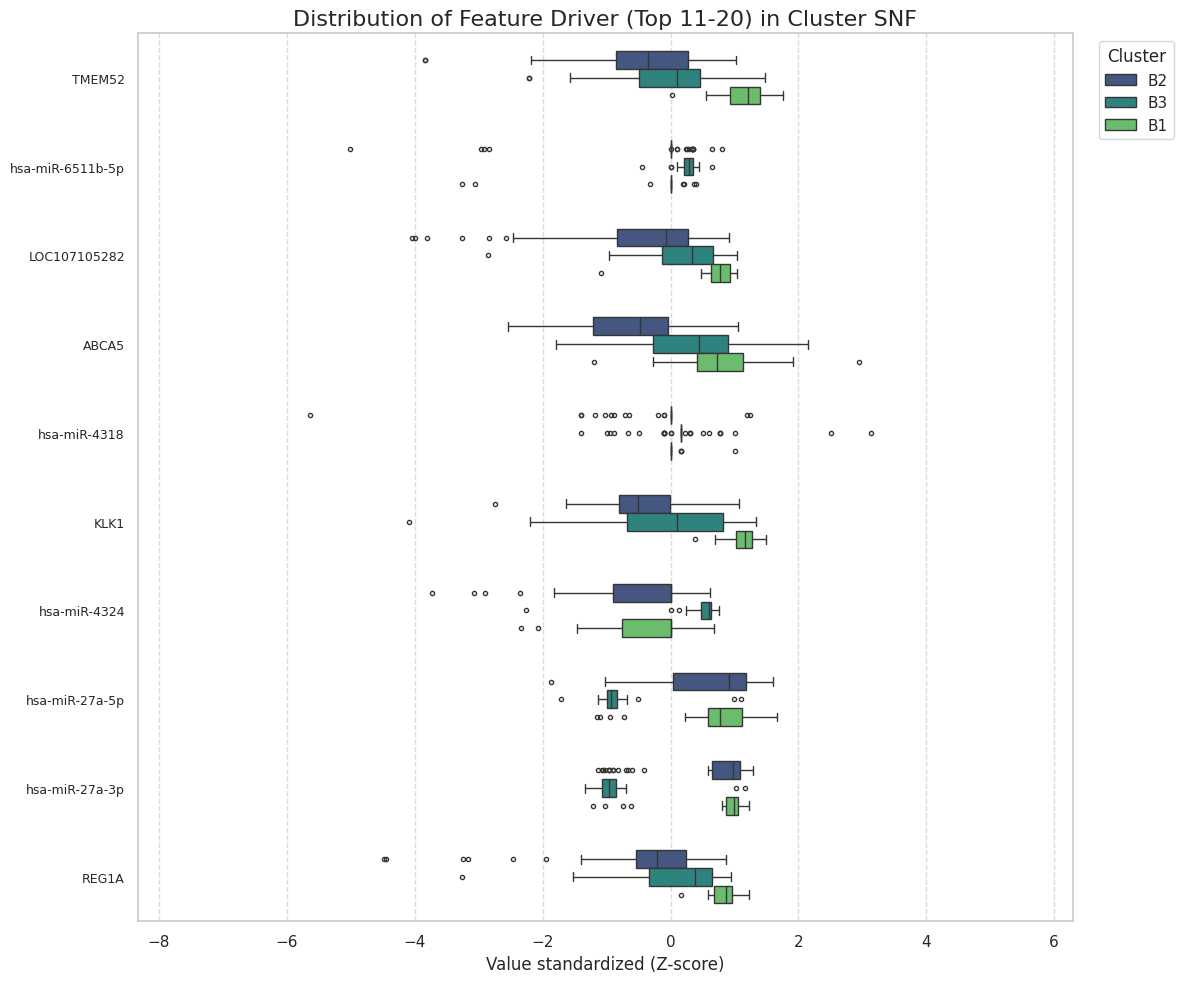


--- Grafico 3/5 (Feature 21 - 30) ---


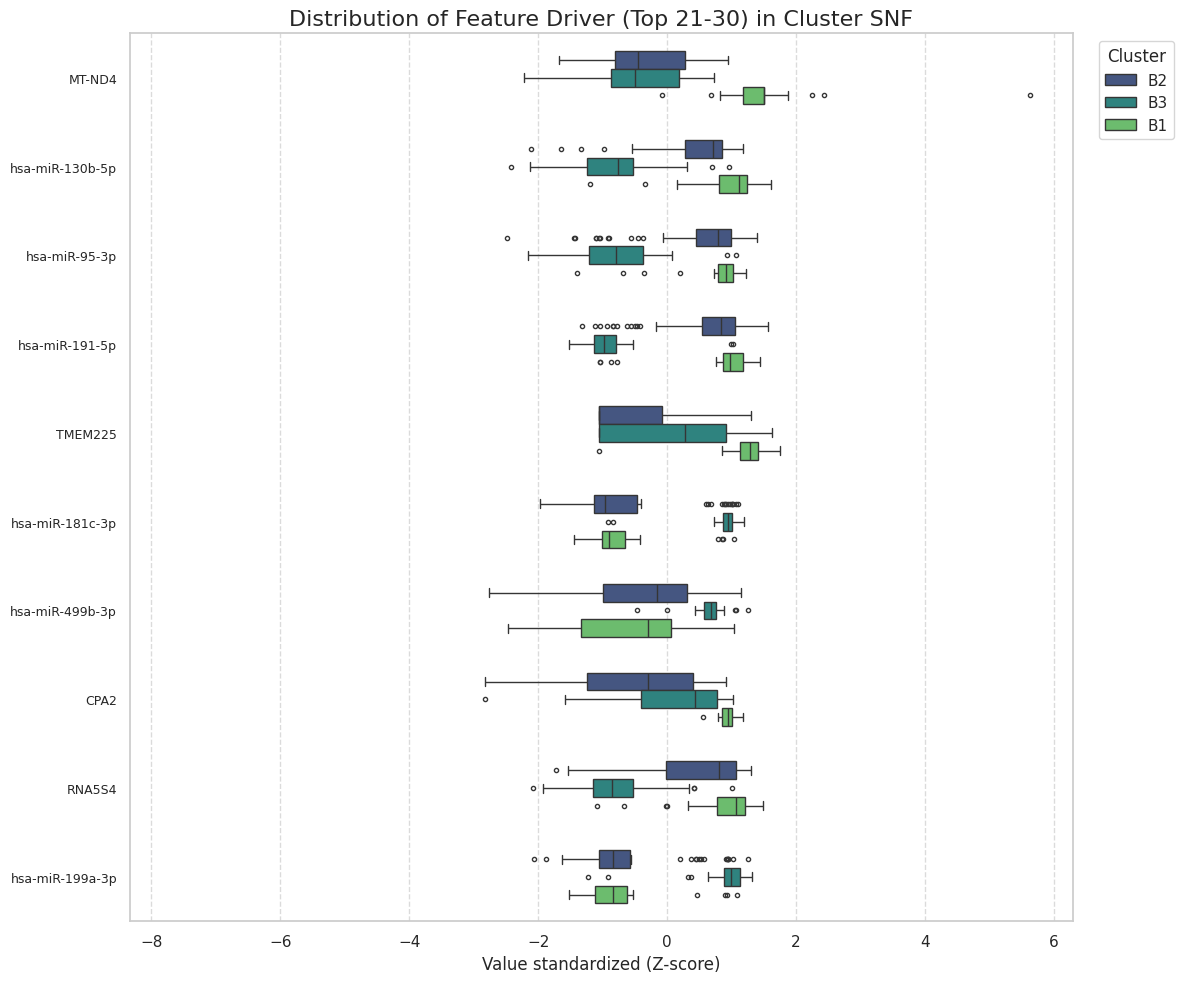


--- Grafico 4/5 (Feature 31 - 40) ---


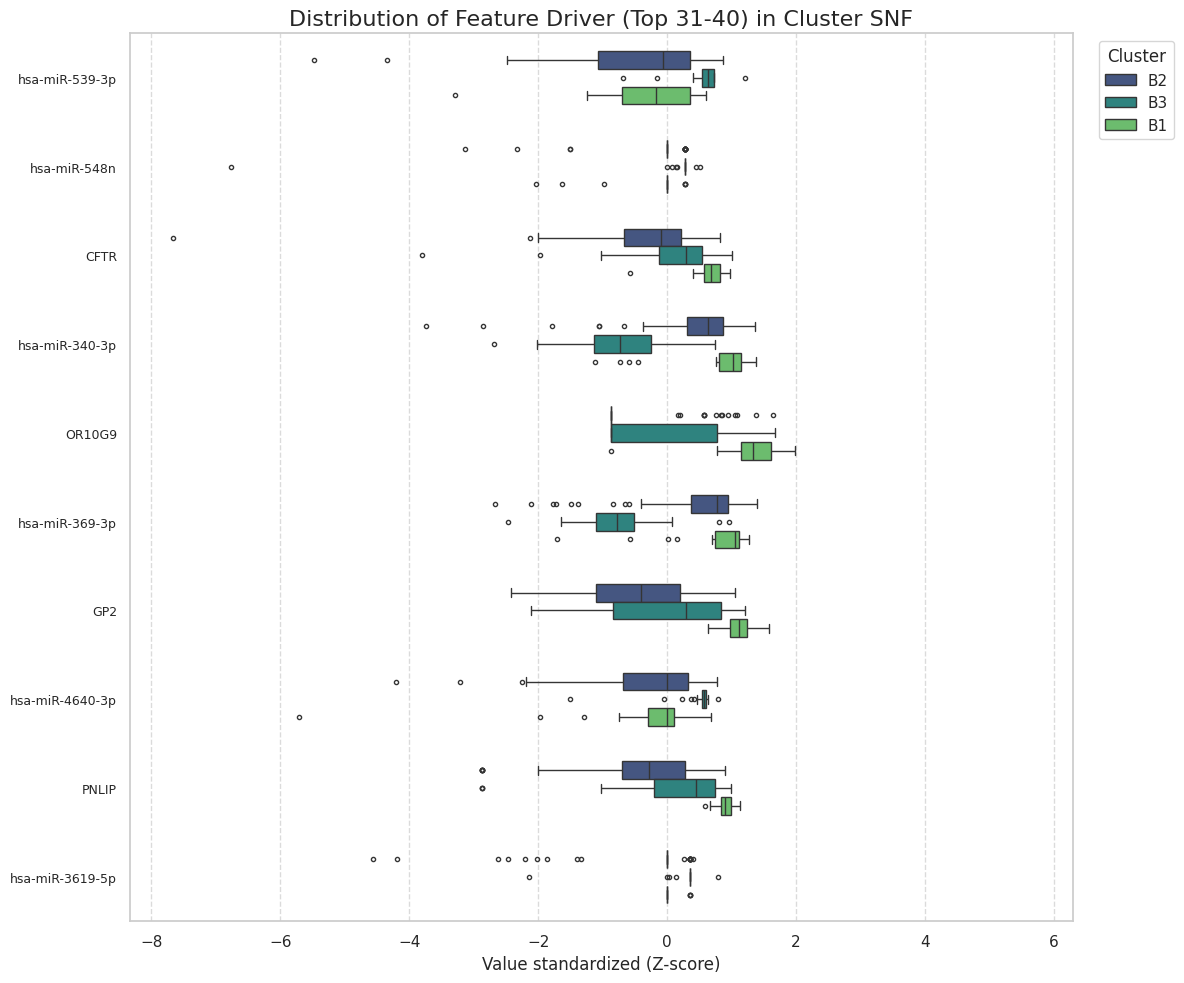


--- Grafico 5/5 (Feature 41 - 50) ---


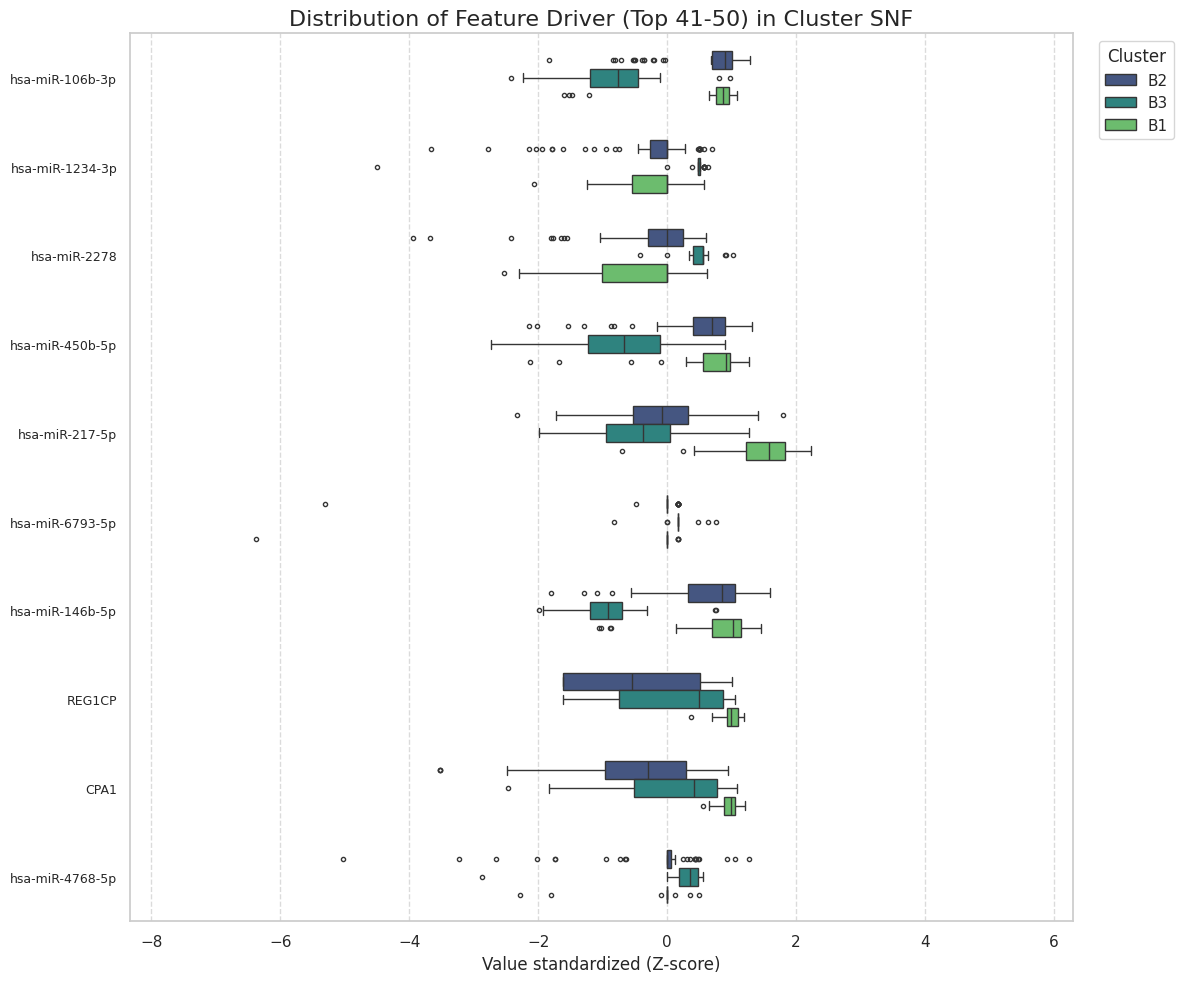


--- FASE 3 (SNF) COMPLETATA ---
Abbiamo identificato i cluster, li abbiamo validati con MCC
e abbiamo trovato i driver biologici (feature) con Random Forest.


In [ ]:
# =======================================================================
#    PROGETTO PDAC - FASE 3 (Track 2): VALIDAZIONE E INTERPRETAZIONE (RF)
# =======================================================================
#
# OBIETTIVO:
# 1. Validazione Esterna: Calcolare l'MCC tra i cluster SNF (Set B)
#    e le variabili cliniche note (es. 'vital_status').
# 2. Feature Importance: Usare la Random Forest per trovare i "driver"
#    biologici che definiscono i cluster B.
# 3. Visualizzazione: Creare 5 boxplot orizzontali (10 feature l'uno)
#    per una migliore leggibilità.
#
# PREREQUISITO:
# Eseguire DOPO la cella della Fase 2. Richiede le variabili:
# - 'cluster_labels_str' (le etichette B1, B2, B3...)
# - 'scaled_omics_dfs' (tutti i dati omici per l'addestramento)
# - 'f_clin_aligned' (i dati clinici originali)
# - 'f_clin_imputed' (i dati clinici imputati, CREATI IN FASE 0)
#
# =======================================================================

print("--- Avvio Fase 3 (Track 2): Validazione e Interpretazione (RF) ---")

# --- 1. IMPORT LIBRERIE NECESSARIE ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, confusion_matrix
import warnings
from sklearn.exceptions import DataConversionWarning # Importa l'avviso

# IGNORA I WARNING (non sono errori)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DataConversionWarning)


# --- 2. CONTROLLO PREREQUISITI FASE 2 ---
print("\n--- 2. Controllo Dati Fase 2 ---")
try:
    # Controlla se le variabili esistono
    _ = scaled_omics_dfs
    _ = f_clin_aligned
    _ = f_clin_imputed  # <-- Variabile chiave dalla Fase 0
    _ = cluster_labels_str # <-- Variabile chiave dalla Fase 2
    print("Dati delle Fasi 0, 1 e 2 trovati. Inizio calcolo.")
except NameError as e:
    print(f"ERRORE: Variabile richiesta non trovata: {e}")
    print("SOLUZIONE: Esegui prima le celle delle Fasi 0, 1 e 2.")
    raise

# =======================================================================
# --- 3. STEP 1: VALIDAZIONE ESTERNA (MCC) ---
# =======================================================================
print("\n" + "="*70)
print("###   Step 1: Validazione Esterna (Matthews Correlation Coefficient)   ###")
print("="*70)
#
# SPIEGAZIONE (MCC): Il Matthews Correlation Coefficient (MCC) è un
# punteggio che misura la qualità di una classificazione. È considerato
# molto robusto, specialmente se i gruppi (cluster) hanno dimensioni diverse.
# - Varia da -1 a +1:
#   - +1: Accordo perfetto (i cluster B corrispondono perfettamente a 'vital_status')
#   -  0: Risultato casuale (nessuna correlazione)
#   - -1: Disaccordo perfetto (i cluster sono l'esatto opposto)
# Validazione Slide (SimNetX.pdf, p. 13, Eq. 15):
#

# Scegli una variabile clinica da 'f_clin_aligned' per il confronto
clinical_variable_to_compare = 'vital_status'

if clinical_variable_to_compare in f_clin_aligned.columns:

    # Usiamo 'f_clin_imputed' (senza NaN)
    true_labels = f_clin_imputed[clinical_variable_to_compare]

    # --- FIX: Allinea gli indici ---
    # Crea una Series per i cluster (pred_labels) usando lo STESSO indice
    # (i nomi dei pazienti) di true_labels.
    pred_labels_series = pd.Series(cluster_labels_str,
                                   name="Cluster SNF",
                                   index=true_labels.index)

    # Calcola l'MCC (ora le etichette sono allineate)
    mcc_score = matthews_corrcoef(true_labels, pred_labels_series)

    print(f"Validazione MCC tra Cluster SNF (B1, B2, B3) e '{clinical_variable_to_compare}':")
    print(f"MCC Score = {mcc_score:.4f}")

    if mcc_score > 0.4:
        print("INTERPRETAZIONE: C'è una correlazione positiva da moderata a forte.")
    elif mcc_score > 0.1:
        print("INTERPRETAZIONE: C'è una correlazione debole. I cluster sono parzialmente allineati.")
    else:
        print("INTERPRETAZIONE: Correlazione bassa o assente. I cluster SNF descrivono")
        print(f"una biologia diversa da '{clinical_variable_to_compare}'.")

    # Mostra una matrice di confusione (ora funzionerà)
    print("\nMatrice di Confusione (Righe=Cluster SNF, Colonne=Classi Cliniche):")
    conf_matrix = pd.crosstab(pred_labels_series, true_labels)
    print(conf_matrix)
else:
    print(f"ATTENZIONE: Variabile '{clinical_variable_to_compare}' non trovata. Salto calcolo MCC.")


# =======================================================================
# --- 4. STEP 2: FEATURE IMPORTANCE (RANDOM FOREST) ---
# =======================================================================
print("\n" + "="*70)
print("###   Step 2: Calcolo Feature Importance (Random Forest)   ###")
print("="*70)
#
# Validazione Slide (RF_lecture_Stanford_ele.pdf, p. 38, 41):
# Addestriamo una Random Forest per predire a quale cluster (B1, B2, B3)
# appartiene un paziente, usando TUTTI i suoi dati omici.
# L'importanza è basata sulla "riduzione dell'Indice di Gini".
#

# 1. Prepara i dati per l'addestramento
print("  > Preparazione dati: unione di tutti i 6 dataset omici...")
all_omics_data = pd.concat(scaled_omics_dfs.values(), axis=1)
all_omics_data = all_omics_data.loc[:, ~all_omics_data.columns.duplicated()]

X = all_omics_data
y = cluster_labels_str  # Le nostre etichette B1, B2, B3

print(f"  > Matrice X creata: {X.shape} (Pazienti, Features Totali)")
print(f"  > Vettore y creato: {len(y)} (Etichette Cluster)")

# 2. Addestra la Random Forest
print("\n  > Addestramento Random Forest in corso (potrebbe richiedere un minuto)...")
rf_model = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf_model.fit(X, y)

print("  > Addestramento completato.")

# 3. Estrai la Feature Importance
print("  > Estrazione della Gini Feature Importance...")
importances = rf_model.feature_importances_

# 4. Crea una classifica
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Stampa i Top 20 "Driver" Biologici
print("\n--- CLASSIFICA TOP 20 DRIVER BIOLOGICI (per i cluster SNF) ---")
print(feature_importance_df.head(20).to_string())


# =======================================================================
# --- 5. STEP 3: VISUALIZZAZIONE (BOXPLOT STILE SimNetX) ---
# =======================================================================
print("\n" + "="*70)
print("###   Step 3: Visualizzazione Driver Biologici (Boxplot)   ###")
print("="*70)
#
# Validazione Slide (SimNetX.pdf, p. 7, 23, 25):
# Creiamo dei boxplot per visualizzare come i valori
# delle feature più importanti cambiano tra i cluster.
#

# 1. Prendi le Top 50 feature
TOP_N_FEATURES = 50
top_features = feature_importance_df.head(TOP_N_FEATURES)['Feature'].tolist()

# 2. Prepara i dati per il plotting
# --- FIX: Aggiungi .copy() per evitare il SettingWithCopyWarning ---
plot_data = X[top_features].copy()
plot_data['Cluster'] = y

# 3. "Fondi" il DataFrame in formato "long" per Seaborn
plot_data_melted = plot_data.melt(id_vars='Cluster',
                                  var_name='Feature',
                                  value_name='Valore (Z-score)')

print(f"  > Preparazione di 5 Boxplot per le Top {TOP_N_FEATURES} feature...")

# --- Creazione di 5 grafici separati (Faceting) con la stessa scala X ---
# Calcola limiti globali su tutte le Top N features
global_min = plot_data_melted['Valore (Z-score)'].min()
global_max = plot_data_melted['Valore (Z-score)'].max()
# Aggiungi un piccolo padding (5%)
pad = (global_max - global_min) * 0.05 if (global_max - global_min) != 0 else 0.5
xlim_lower = global_min - pad
xlim_upper = global_max + pad

print(f"  > Limiti asse X globali impostati: [{xlim_lower:.3f}, {xlim_upper:.3f}]")
print(f"  > Preparazione di 5 Boxplot per le Top {TOP_N_FEATURES} feature...")

N_PLOTS = 5
FEATURES_PER_PLOT = TOP_N_FEATURES // N_PLOTS # 10

for i in range(N_PLOTS):
    start_index = i * FEATURES_PER_PLOT
    end_index = (i + 1) * FEATURES_PER_PLOT

    # Seleziona il "chunk" di feature per questo grafico
    features_chunk = top_features[start_index:end_index]

    # Filtra il DataFrame fuso per contenere solo queste 10 feature
    plot_chunk = plot_data_melted[plot_data_melted['Feature'].isin(features_chunk)]

    print(f"\n--- Grafico {i+1}/{N_PLOTS} (Feature {start_index+1} - {end_index}) ---")

    # 4. Crea il Boxplot orizzontale
    plt.figure(figsize=(12, 10))  # Alto e stretto
    sns.boxplot(
        data=plot_chunk,
        x='Valore (Z-score)', # Asse X
        y='Feature',          # Asse Y
        hue='Cluster',
        palette='viridis',
        orient='h',           # Orientamento orizzontale
        order=features_chunk, # Mantiene l'ordine di importanza
        width=0.6,            # Boxplot più "magri"
        fliersize=3           # Outlier (cerchi) più piccoli
    )
    # Applica gli stessi limiti X a tutti i grafici
    plt.xlim(xlim_lower, xlim_upper)

    # (opzionale) uniforma i ticks sull'asse X se vuoi
    # import numpy as np
    # plt.xticks(np.linspace(xlim_lower, xlim_upper, 7))

    plt.title(f"Distribution of Feature Driver (Top {start_index+1}-{end_index}) in Cluster SNF", fontsize=16)
    plt.xlabel("Value standardized (Z-score)")
    plt.ylabel("")
    plt.yticks(fontsize=9)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.legend(title='Cluster', bbox_to_anchor=(1.02, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

# --- Commento Finale ---
print("\n" + "="*70)
print("--- FASE 3 (SNF) COMPLETATA ---")
print("Abbiamo identificato i cluster, li abbiamo validati con MCC")
print("e abbiamo trovato i driver biologici (feature) con Random Forest.")


********************************************************************************
###Fase 4: Finale A/B
********************************************************************************

--- FASE 4: SINTESI E VALIDAZIONE (CELLA UNICA E CORRETTA) ---

--- 1. Preparazione Dati ---
Mappatura variabili cluster...
Creazione DataFrame di validazione...
Colonna Evento 'OS_status' creata da 'vital_status_Living'.
Colonna Outcome 'Advanced_Stage' creata da Stadio III e IV.
Utilizzando 137 pazienti dopo aver rimosso NaN clinici.

--- 2. Validazione Interna (Silhouette) ---
Silhouette Score (Track 1 - PCA): 0.1019
Silhouette Score (Track 2 - SNF): 0.0003

--- 3. Validazione Incrociata (Overlap) ---
Overlap (MCC) tra Track 1 e Track 2: -0.0356
Overlap (NMI) tra Track 1 e Track 2: 0.2533

--- 4. Validazione Clinica (Kaplan-Meier) ---
Errore Log-Rank per Cluster_A: cannot convert the series to <class 'int'>.
Plot Kaplan-Meier saved as: kaplan_meier_Cluster_A.png


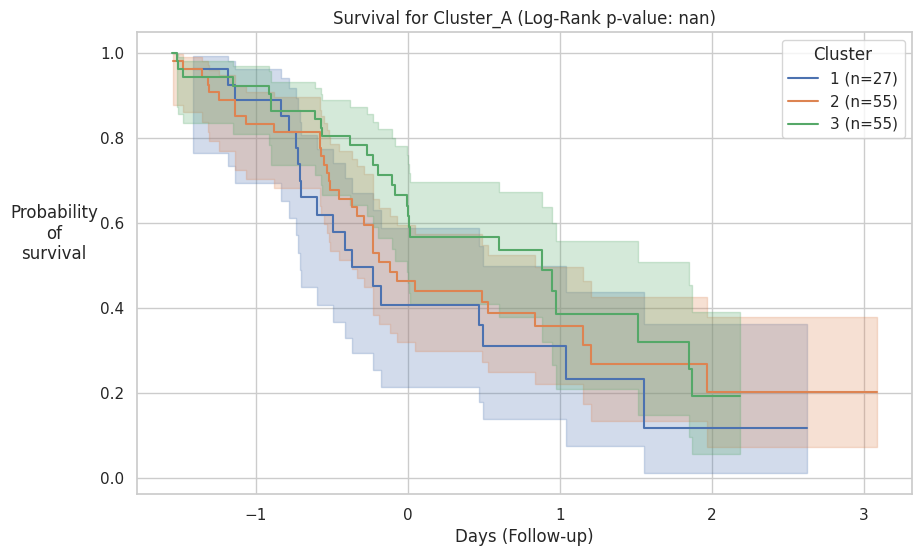

Result Log-Rank Test for Cluster_A: p = nan
Errore Log-Rank per Cluster_B: inputs must be of the same length..
Plot Kaplan-Meier saved as: kaplan_meier_Cluster_B.png


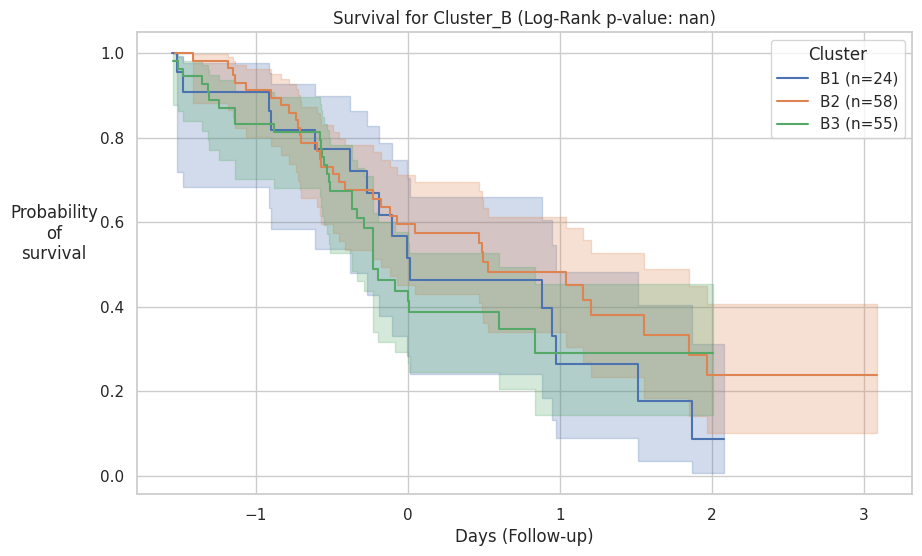

Result Log-Rank Test for Cluster_B: p = nan

--- 5. Validazione Clinica (Odds Ratios) ---

Esecuzione Regressione Logistica per Cluster_A (Ref: 1)...
                           Logit Regression Results                           
Dep. Variable:         Advanced_Stage   No. Observations:                  137
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                            4
Date:                Fri, 21 Nov 2025   Pseudo R-squ.:                 0.04024
Time:                        07:07:56   Log-Likelihood:                -85.738
converged:                       True   LL-Null:                       -89.333
Covariance Type:            nonrobust   LLR p-value:                    0.1262
                                                  coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------

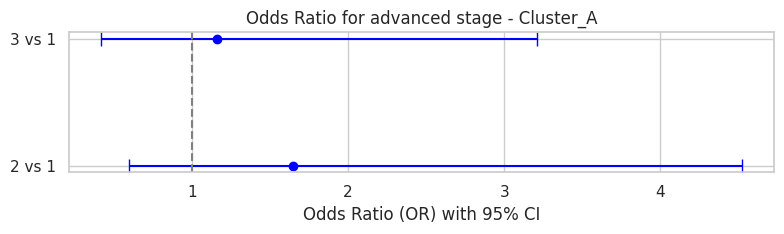


Esecuzione Regressione Logistica per Cluster_B (Ref: B1)...
                           Logit Regression Results                           
Dep. Variable:         Advanced_Stage   No. Observations:                  137
Model:                          Logit   Df Residuals:                      132
Method:                           MLE   Df Model:                            4
Date:                Fri, 21 Nov 2025   Pseudo R-squ.:                 0.03791
Time:                        07:07:57   Log-Likelihood:                -85.946
converged:                       True   LL-Null:                       -89.333
Covariance Type:            nonrobust   LLR p-value:                    0.1483
                                                    coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------
Intercept                                        -0.5506      0.460     -1.196 

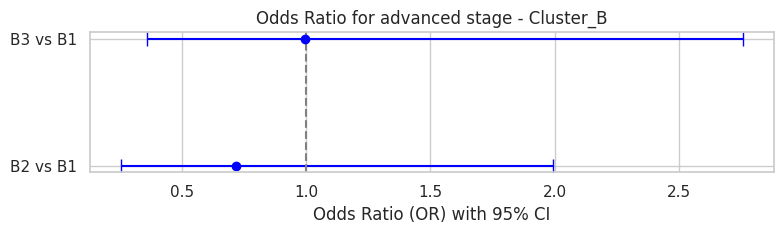


--- 6. Validazione Biologica (Feature Importance) ---

Training Random Forest per Cluster A...
Top 10 Drivers per Cluster A:
         Feature  Importance
25499     TMEM97    0.003697
40814     TMEM51    0.003329
37028       NKD2    0.003117
10280  LINC00261    0.002868
35428      KCNQ1    0.002861
30806        AK5    0.002588
33948      FBLN2    0.002475
10794  LINC01152    0.002433
49090   TMEM200B    0.002421
40672       TLN1    0.002399

Training Random Forest per Cluster B...
Top 10 Drivers per Cluster B:
               Feature  Importance
28535   hsa-miR-23a-3p    0.004484
28557   hsa-miR-27a-5p    0.003595
29287  hsa-miR-4713-5p    0.003492
28399   hsa-miR-185-5p    0.003059
29604   hsa-miR-539-3p    0.002779
29448   hsa-miR-490-3p    0.002778
28786  hsa-miR-3613-5p    0.002733
28328   hsa-miR-142-5p    0.002696
28533  hsa-miR-2355-5p    0.002622
29938  hsa-miR-664a-5p    0.002588

--- FASE 4 COMPLETATA ---


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, normalized_mutual_info_score, matthews_corrcoef
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
import statsmodels.formula.api as smf
import warnings

# --- INIZIO CELLA UNICA FASE 4 ---
print("--- FASE 4: SINTESI E VALIDAZIONE (CELLA UNICA E CORRETTA) ---")
warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

# ======================================================================
# --- 1. CONFIGURAZIONE E PREPARAZIONE DATI ---
# ======================================================================

# Nomi delle variabili cluster definite nelle celle PRECEDENTI
NOME_VARIABILE_CLUSTER_A = 'plot_labels'        # Dalla cella Track 1
NOME_VARIABILE_CLUSTER_B = 'cluster_labels_str' # Dalla cella Track 2

# Nomi delle colonne cliniche IDENTIFICATI dal tuo output
COLONNA_GIORNI_SOPRAVVIVENZA = 'follow_up_days'
COLONNA_VITAL_STATUS = 'vital_status_Living' # Usato per creare l'evento
COLONNA_STADIO_3 = 'tumor_stage_pathological_Stage III'
COLONNA_STADIO_4 = 'tumor_stage_pathological_Stage IV'
COLONNA_SEX = 'sex_Male' # La colonna 'sex' è già one-hot

try:
    # --- Mappatura Variabili Cluster (Ponte) ---
    print("\n--- 1. Preparazione Dati ---")
    print("Mappatura variabili cluster...")
    cluster_labels_A_str = locals()[NOME_VARIABILE_CLUSTER_A]
    cluster_labels_B_str = locals()[NOME_VARIABILE_CLUSTER_B]

    # Assicura che i cluster siano pd.Series con l'indice corretto
    if isinstance(cluster_labels_B_str, list):
        cluster_labels_B_str = pd.Series(cluster_labels_B_str, index=f_clin_final.index, name="Cluster_B")
    if isinstance(cluster_labels_A_str, list):
         cluster_labels_A_str = pd.Series(cluster_labels_A_str, index=f_clin_final.index, name="Cluster_A")
    elif isinstance(cluster_labels_A_str, pd.Series):
         cluster_labels_A_str.index = f_clin_final.index

    # --- Creazione DataFrame di Validazione ---
    print("Creazione DataFrame di validazione...")
    validation_df = f_clin_final.copy()

    # --- Creazione Colonna Evento (OS_status) ---
    # 1 = Evento (Deceduto), 0 = Censurato (Vivo)
    validation_df['OS_status'] = 1 - validation_df[COLONNA_VITAL_STATUS]
    print(f"Colonna Evento 'OS_status' creata da '{COLONNA_VITAL_STATUS}'.")

    # --- Creazione Colonna Outcome (Advanced_Stage) ---
    # 1 = Stadio III o IV, 0 = Altrimenti
    validation_df['Advanced_Stage'] = (
        (validation_df[COLONNA_STADIO_3] == 1) |
        (validation_df[COLONNA_STADIO_4] == 1)
    ).astype(int)
    print(f"Colonna Outcome 'Advanced_Stage' creata da Stadio III e IV.")

    # Aggiunta cluster e gestione Tipi/NaN
    validation_df['Cluster_A'] = cluster_labels_A_str.values
    validation_df['Cluster_B'] = cluster_labels_B_str.values

    validation_df[COLONNA_GIORNI_SOPRAVVIVENZA] = pd.to_numeric(validation_df[COLONNA_GIORNI_SOPRAVVIVENZA], errors='coerce')
    validation_df['OS_status'] = pd.to_numeric(validation_df['OS_status'], errors='coerce')
    validation_df['Advanced_Stage'] = pd.to_numeric(validation_df['Advanced_Stage'], errors='coerce')

    colonne_da_controllare = [COLONNA_GIORNI_SOPRAVVIVENZA, 'OS_status', 'Advanced_Stage', 'age', COLONNA_SEX]
    validation_df = validation_df.dropna(subset=colonne_da_controllare)
    print(f"Utilizzando {len(validation_df)} pazienti dopo aver rimosso NaN clinici.")

# ======================================================================
# --- 2. VALIDAZIONE INTERNA (SILHOUETTE) ---
# ======================================================================
    print("\n--- 2. Validazione Interna (Silhouette) ---")

    le = LabelEncoder()
    # Allineo le etichette al df filtrato
    labels_A_num = le.fit_transform(validation_df['Cluster_A'])
    labels_B_num = le.fit_transform(validation_df['Cluster_B'])

    # Allineo i dati dei fattori
    data_for_silhouette_A = latent_factors_df.drop(columns=['Cluster_A'], errors='ignore').loc[validation_df.index]
    score_A = silhouette_score(data_for_silhouette_A, labels_A_num)
    print(f"Silhouette Score (Track 1 - PCA): {score_A:.4f}")

    # Allineo la matrice di distanza
    distance_matrix_B = (1 - fused_matrix)
    idx = f_clin_final.index.get_indexer(validation_df.index)
    distance_matrix_B = distance_matrix_B[idx, :][:, idx]
    np.fill_diagonal(distance_matrix_B, 0) # Correzione diagonale

    score_B = silhouette_score(distance_matrix_B, labels_B_num, metric='precomputed')
    print(f"Silhouette Score (Track 2 - SNF): {score_B:.4f}")

# ======================================================================
# --- 3. VALIDAZIONE INCROCIATA (OVERLAP) ---
# ======================================================================
    print("\n--- 3. Validazione Incrociata (Overlap) ---")
    mcc = matthews_corrcoef(labels_A_num, labels_B_num)
    nmi = normalized_mutual_info_score(labels_A_num, labels_B_num)
    print(f"Overlap (MCC) tra Track 1 e Track 2: {mcc:.4f}")
    print(f"Overlap (NMI) tra Track 1 e Track 2: {nmi:.4f}")

# ======================================================================
# --- 4. VALIDAZIONE CLINICA (KAPLAN-MEIER) ---
# ======================================================================
    print("\n--- 4. Validazione Clinica (Kaplan-Meier) ---")

    def plot_kaplan_meier(df, cluster_col):
        plt.figure(figsize=(10, 6))
        ax = plt.subplot(111)
        kmf = KaplanMeierFitter()
        clusters = sorted(df[cluster_col].unique())

        for cluster in clusters:
            cluster_data = df[df[cluster_col] == cluster]
            kmf.fit(cluster_data[COLONNA_GIORNI_SOPRAVVIVENZA].astype(float), # CORREZIONE TIPO
                    cluster_data['OS_status'].astype(float),                 # CORREZIONE TIPO
                    label=f'{cluster} (n={len(cluster_data)})')
            kmf.plot_survival_function(ax=ax)

        try:
            # CORREZIONE: Assicura che i dati passati al test siano liste di float
            tempi = [df[df[cluster_col] == c][COLONNA_GIORNI_SOPRAVVIVENZA].astype(float) for c in clusters]
            eventi = [df[df[cluster_col] == c]['OS_status'].astype(float) for c in clusters]
            results = logrank_test(*tempi, *eventi)
            p_value = results.p_value
        except Exception as e:
            print(f"Errore Log-Rank per {cluster_col}: {e}.")
            p_value = np.nan

        plt.title(f'Survival for {cluster_col} (Log-Rank p-value: {p_value:.5f})')
        plt.xlabel('Days (Follow-up)')
        plt.ylabel('Probability\nof\nsurvival', rotation=0, labelpad=33)
        plt.legend(title="Cluster")
        plot_filename = f"kaplan_meier_{cluster_col}.png"
        plt.savefig(plot_filename)
        print(f"Plot Kaplan-Meier saved as: {plot_filename}")
        plt.show()
        print(f"Result Log-Rank Test for {cluster_col}: p = {p_value:.5f}")

    plot_kaplan_meier(validation_df, 'Cluster_A')
    plot_kaplan_meier(validation_df, 'Cluster_B')

# ======================================================================
# --- 5. VALIDAZIONE CLINICA (LOGISTIC REGRESSION) ---
# ======================================================================
    print("\n--- 5. Validazione Clinica (Odds Ratios) ---")

    def plot_forest_plot(model_results, cluster_col, ref_cluster):
        params = model_results.params
        conf = model_results.conf_int()
        plot_data = []
        # Cerca solo le variabili che iniziano con 'C(cluster_col'
        cluster_vars = [v for v in params.index if v.startswith(f'C({cluster_col}')]

        for var in cluster_vars:
            # CORREZIONE BUG: Splitta su '[T.' e rimuovi ']' finale
            try:
                cluster_name = var.split('[T.')[1].replace(']', '')
            except IndexError:
                print(f"Debug: Impossibile parsare la variabile '{var}'")
                continue

            plot_data.append({
                'Cluster': f'{cluster_name} vs {ref_cluster}',
                'OR': np.exp(params[var]),
                'CI_low': np.exp(conf.loc[var][0]),
                'CI_high': np.exp(conf.loc[var][1])
            })

        if not plot_data:
            print(f"Nessun dato da plottare per {cluster_col}.")
            return

        df_plot = pd.DataFrame(plot_data).set_index('Cluster')
        plt.figure(figsize=(8, len(df_plot) * 0.5 + 1.5)) # Altezza dinamica
        plt.errorbar(x=df_plot['OR'], y=df_plot.index,
                     xerr=[df_plot['OR'] - df_plot['CI_low'], df_plot['CI_high'] - df_plot['OR']],
                     fmt='o', capsize=5, color='blue')
        plt.axvline(x=1.0, linestyle='--', color='grey')
        plt.xlabel('Odds Ratio (OR) with 95% CI')
        plt.title(f'Odds Ratio for advanced stage - {cluster_col}')
        plt.tight_layout()
        plot_filename = f"forest_plot_{cluster_col}.png"
        plt.savefig(plot_filename)
        print(f"Forest Plot salvato come: {plot_filename}")
        plt.show()

    def run_logistic_regression(df, cluster_col):
        ref_cluster = sorted(df[cluster_col].unique())[0]
        # Usa i nomi corretti: 'Advanced_Stage', 'age', 'sex_Male'
        # statsmodels gestirà 'sex_Male' (0/1) automaticamente
        formula = f"Advanced_Stage ~ C({cluster_col}, Treatment(reference='{ref_cluster}')) + age + {COLONNA_SEX}"

        print(f"\nEsecuzione Regressione Logistica per {cluster_col} (Ref: {ref_cluster})...")

        try:
            model = smf.logit(formula, data=df).fit(disp=0)
            print(model.summary())
            plot_forest_plot(model, cluster_col, ref_cluster)
        except Exception as e:
            print(f"Errore durante la regressione per {cluster_col}: {e}")

    run_logistic_regression(validation_df, 'Cluster_A')
    run_logistic_regression(validation_df, 'Cluster_B')

# ======================================================================
# --- 6. VALIDAZIONE BIOLOGICA (RANDOM FOREST) ---
# ======================================================================
    print("\n--- 6. Validazione Biologica (Feature Importance) ---")
    full_omic_data = pd.concat(scaled_omics_dfs.values(), axis=1)
    # Allinea i dati omici con i dati clinici filtrati (dopo il dropna)
    full_omic_data_aligned = full_omic_data.loc[validation_df.index]

    def get_rf_importance(X, y, cluster_col_name):
        print(f"\nTraining Random Forest per {cluster_col_name}...")
        le_rf = LabelEncoder()
        y_encoded = le_rf.fit_transform(y)
        rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
        rf.fit(X, y_encoded)
        importances = pd.DataFrame({
            'Feature': X.columns,
            'Importance': rf.feature_importances_
        }).sort_values(by='Importance', ascending=False)
        print(f"Top 10 Drivers per {cluster_col_name}:")
        print(importances.head(10))
        return importances

    # Usiamo i dati allineati
    rf_drivers_A = get_rf_importance(full_omic_data_aligned, validation_df['Cluster_A'], 'Cluster A')
    rf_drivers_B = get_rf_importance(full_omic_data_aligned, validation_df['Cluster_B'], 'Cluster B')

    print("\n--- FASE 4 COMPLETATA ---")

except NameError as e:
    print(f"ERRORE CRITICO DI ESECUZIONE: Variabile non trovata: {e}")
    print("Assicurati di aver eseguito TUTTE le celle precedenti (Fase 0, 1, 2...)")
    print("Controlla anche i nomi 'NOME_VARIABILE_CLUSTER_A' e 'NOME_VARIABILE_CLUSTER_B' all'inizio di questa cella.")
except Exception as e:
    print(f"ERRORE CRITICO IMPREVISTO: {e}")

# --- FINE CELLA UNICA FASE 4 ---